# Residus & Outliers

Extension of the Kaggle House Pricing notebook as the study of outliers required more attention. 
For resources refer to its Sources


### A. Plot residuals of linear regression for target values Y, Y^1/2 , log(1+Y)
### B. Cook theory : Leverage VS Influencial points  / Assume Hat matrice is non singuliar
### C. Error-based outliers : train model with dataset which has 95% lowest error : cheating with the result ?
### D. Intuitive outliers : an impossible task for Machine Learning ?        
    
-----------------------------------------------------------------------------------------------------------

## A. Plot residuals of linear regression for target values Y, Y^1/2 , Y^1/3,  log(1+Y)

#### 1) Use Pipeline and fit the dataset

In [2]:
# The idea it to be able to re use the code for other data sets

import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import seaborn as sns
import cmath

import matplotlib.pylab as pylab
%matplotlib inline

# Let's load the regression linear model
from sklearn import linear_model
reg = linear_model.LinearRegression()

In [3]:
# Let's load the data an store in train and set
train = pd.read_csv('train.csv',sep=',')
test = pd.read_csv('test.csv',sep=',')
train.head()

# prep train data
label_col = "SalePrice"
index_col = "Id"
xtest = test.drop([index_col], axis=1)
xtrain = train.drop([index_col, label_col], axis=1)
y = np.log1p(train[label_col])

# all data, combo dataframe
housing = pd.concat([xtrain, xtest])

In [4]:
# We also need the pipeline to transform the datas
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
#from sklearn.preprocessing import CategoricalEncoder
from sklearn.preprocessing import Imputer

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin #gives fit_transform method for free
from sklearn.base import BaseEstimator, TransformerMixin

class CustomLabelBinarizer(BaseEstimator, TransformerMixin):
    """Perform one-hot encoding to categorical features."""
    def __init__(self, cat_features):
        self.cat_features = cat_features

    def fit(self, X_cat, y=None):
        return self

    def transform(self, X_cat):
        X_cat_df = pd.DataFrame(X_cat, columns=self.cat_features)
        X_onehot_df = pd.get_dummies(X_cat_df, columns=self.cat_features)
        return X_onehot_df.values

class MissingSelector(BaseEstimator, TransformerMixin):
    def __init__(self, ratio):
        self.ratio = ratio
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return drop_missing(X, self.ratio)
    
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
    def fit(self, X):
        return self
    def transform(self, X):
        return X[self.feature_names]
    
class CustomNoCustomUnskewerrmalizer(BaseEstimator, TransformerMixin):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return ((X - self.mean) / self.std)
    
class CustomNormalizer(BaseEstimator, TransformerMixin):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return scaler.fit_transform(X)


train = pd.read_csv('train.csv',sep=',')
test = pd.read_csv('test.csv',sep=',')
train.head()
    
# prep train data
label_col = "SalePrice"
index_col = "Id"
xtest = test.drop([index_col], axis=1)
xtrain = train.drop([index_col, label_col], axis=1)
y = np.log1p(train[label_col])

# all data, combo dataframe
housing = pd.concat([xtrain, xtest])


# Let's create a pipeline for categories and numerics


num_attribs = [e for e in housing.columns if housing[e].dtype in [np.int64, np.int32, np.float64, np.float32]]
cat_attribs = [e for e in housing.columns if e not in num_attribs]


num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        #('attribs_adder', CombineAttributesAdder()),
        #('std_scaler', StandardScaler()),
])


cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        #('cat_encoder', CategoricalEncoder()),
        #('label_encoder', LabelEncoder()),
        ('cat_encoder', CustomLabelBinarizer(cat_attribs)),
])



# Now let's consolidate the full pipeline
full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
])

samples = xtrain.shape[0] # number of training samples
housing_prepared = full_pipeline.fit_transform(housing)

xtrain = housing_prepared[:samples]
xtest = housing_prepared[samples:]

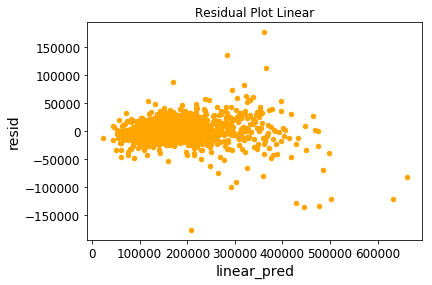

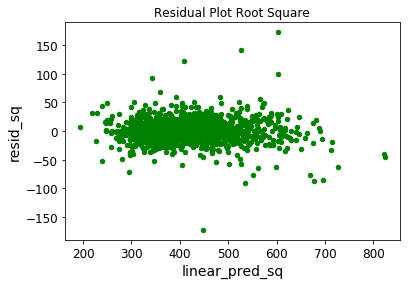

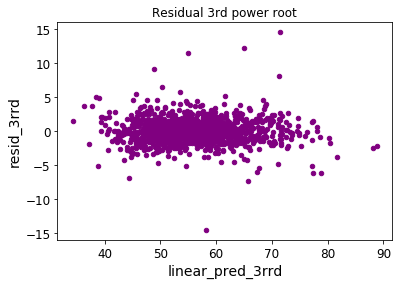

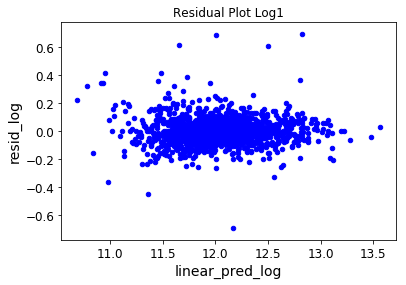

In [5]:
# Let's review homoscedaticity by plotting the residuals 
train = pd.read_csv('train.csv',sep=',')
test = pd.read_csv('test.csv',sep=',')
train.head()
    
# prep train data
label_col = "SalePrice"
index_col = "Id"
y = train[label_col]

reg = linear_model.LinearRegression()
reglin = reg.fit(xtrain, y)
reg2 = linear_model.LinearRegression()
reglin2 = reg2.fit(xtrain, np.sqrt(y))
reg3 = linear_model.LinearRegression()
reglin3 = reg3.fit(xtrain, np.power(y,float(1)/float(3)))
reg4 = linear_model.LinearRegression()
reglin4 = reg4.fit(xtrain, np.log1p(y))



pred = pd.DataFrame({
    
    "linear_pred" : reg.predict(xtrain),
    "linear_pred_sq" : reg2.predict(xtrain),
    "linear_pred_3rrd" : reg3.predict(xtrain),
    "linear_pred_log" : reg4.predict(xtrain),
    "resid" : reg.predict(xtrain) - y,
    "resid_sq" : reg2.predict(xtrain) - np.sqrt(y),
    "resid_3rrd" : reg3.predict(xtrain) - np.power(y,float(1)/float(3)),
    "resid_log" : reg4.predict(xtrain)- np.log1p(y),
    #"label" : y,
    #"label_sq" : np.sqrt(y),
    #"label_3rrd" : np.power(y,float(1)/float(3)),
    #"label_log" : np.log1p(y),
})


# prediction and residual plotting
pred.plot(x="linear_pred", y="resid", kind="scatter",color="orange"); plt.title("Residual Plot Linear");
pred.plot(x="linear_pred_sq", y="resid_sq", kind="scatter",color="green"); plt.title("Residual Plot Root Square");
pred.plot(x="linear_pred_3rrd", y="resid_3rrd", kind="scatter",color="purple"); plt.title("Residual 3rd power root");
pred.plot(x="linear_pred_log", y="resid_log", kind="scatter",color="blue"); plt.title("Residual Plot Log1"); 

=> Simple linear model doesn't seem to catch the structure of the relation between our input and our house price as we see the residuals more sparse as the value of the home price grow "heteroscedaticity".

=> by contracting the value of the prediction we get a better random behavior of the residuals at 2nd and 3rd root power. With the log we even see the value of the residuals contracting as price of house grows higher. This is notable and may affect the model too.

We chose to build all models on the Logairthm of the house price because Kaggle Competition ranks prediction by taking the Mean of the error of the log price. Intuitively it is not very nice to make prediction and see results btw 9 to 14, we would like to see the real price in USD right ?

I tend to agree but I have to say it is convenient to compare errors between different models when they are in a [0.09; 0.30] range ( instead of [ 15,000.00 ; 387,659 ]. More important, the distribution of the Logarithm is more similar to Normal distribution. I can't remember why exactly this improves our model ? I searched and can't find anything from my Dauphine's course notes... Can someone give me a good proof for that ?

Now we will make another analysis on the residuals, and QQ plot them with theorical percentiles. ( I should also add a test of Normality if I have the time )

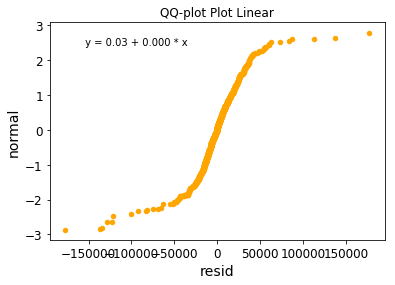

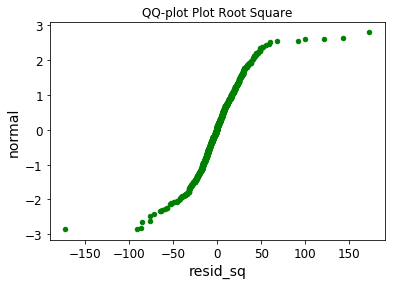

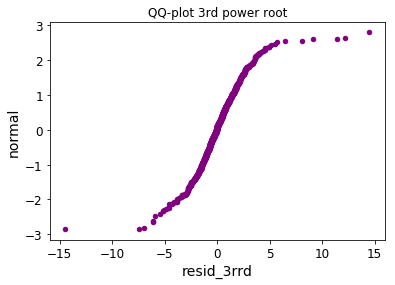

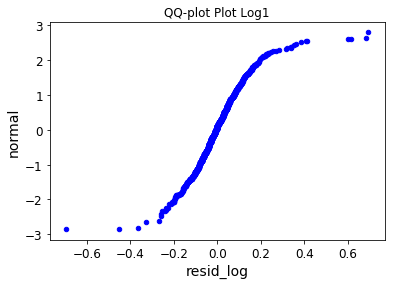

In [6]:
# Now let's do the qq-plot and see how normal are the percentiles distributed
from scipy import stats

normal = np.random.normal(0,1,len(y))

percentiles = pd.DataFrame({
    
    "resid" : np.sort(reg.predict(xtrain) - y),
    "resid_sq" : np.sort(reg2.predict(xtrain) - np.sqrt(y)),
    "resid_3rrd" : np.sort(reg3.predict(xtrain) - np.power(y,float(1)/float(3))),
    "resid_log" : np.sort(reg4.predict(xtrain)- np.log1p(y)),
    "normal" : np.sort(np.random.normal(0,1,len(y))),

})

# qq plot
x = percentiles['resid']
y = percentiles['normal']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
percentiles.plot(x="resid", y="normal", kind="scatter",color="orange"); plt.title("QQ-plot Plot Linear");
plt.figtext(0.2, 0.8, " y = %.2f + %.3f * x " %(intercept,slope));

percentiles.plot(x="resid_sq", y="normal", kind="scatter",color="green"); plt.title("QQ-plot Plot Root Square");
percentiles.plot(x="resid_3rrd", y="normal", kind="scatter",color="purple"); plt.title("QQ-plot 3rd power root");
percentiles.plot(x="resid_log", y="normal", kind="scatter",color="blue"); plt.title("QQ-plot Plot Log1"); 


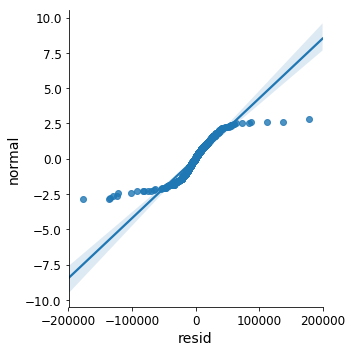

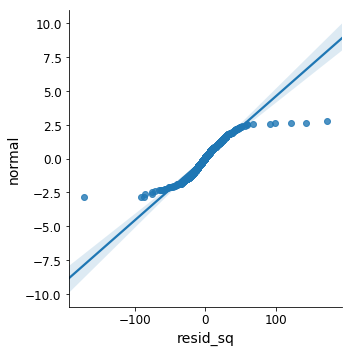

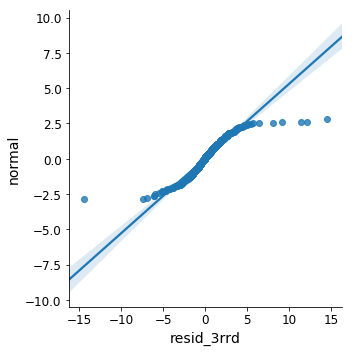

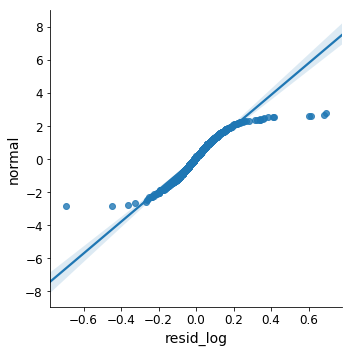

In [7]:
import seaborn as sns

sns.lmplot("resid", "normal",percentiles,fit_reg=True); 
sns.lmplot("resid_sq", "normal",percentiles); 
sns.lmplot("resid_3rrd", "normal",percentiles);
sns.lmplot("resid_log", "normal",percentiles); 

# Now let's compute the influencial points according to Cook theory and plot them in different colors


In [8]:
# avant de calculer les points influent, il faut savoir si la matrice chapeau est inversible, non singuliere
# We need to see the H matric in order to see if it is non singuliar, in an other word that it is inversible. 
# If not we will have to move on to other methods to calculate high leverage points

from __future__ import division
from numpy.linalg import inv

# First we define function to return high leverage points according to cook theory
def cook_distance(X,y,seuil=1):
    # This method i designed for regression model, but we can still use it for other models
    # and his if it improves performance of algorithm
    from numpy.linalg import inv
    
    
    n,m = X.shape
    
    # Hat matrice or projection matrice
    H = X.dot(inv(X.T.dot(X))).dot(X.T)
    
    # residual vector
    e = (np.eye(n)-H).dot(y)
    
    
    # mean square error of regression model
    s2 = 1/(n-m) * np.sum(e**2)

    H2 = H**2
    Hinv2 = 1/(np.eye(n)-H)**2
    e2 = e**2
    
    # Now let's compute the cook distance
    D =  e2 / (s2*m)* (H*Hinv2)
    
    # influencial points 
    #return np.argwhere(D > float(4)/(n-m))
    
    if seuil is None:
        return (np.diag(D)> 4/(n-m))
    else:
        return (np.diag(D)> seuil)

    
def leverage(X):
    # This method i return diagonal elements of H matrice, representing leverage of each point
    from numpy.linalg import inv
    
    n,m = X.shape
    
    # Hat matrice or projection matrice
    H = X.dot(inv(X.T.dot(X))).dot(X.T)
    
    return np.diag(H)


#Check if H matrice is inversible

def H_matrice(X):
    return X.dot(inv(X.T.dot(X))).dot(X.T)

print("Det of Hat matrice: ", np.linalg.det(H_matrice(xtrain)))
print("Rank of xtrain VS number of columns:  (%lf, %lf)" % (np.linalg.matrix_rank(xtrain),xtrain.shape[1]))


Det of Hat matrice:  0.0
Rank of xtrain VS number of columns:  (254.000000, 288.000000)


=> Hat matrice not inversible ( probably because we have identical columns when we encoded categorical features )

C:\Users\BQUIDET\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


'Done'

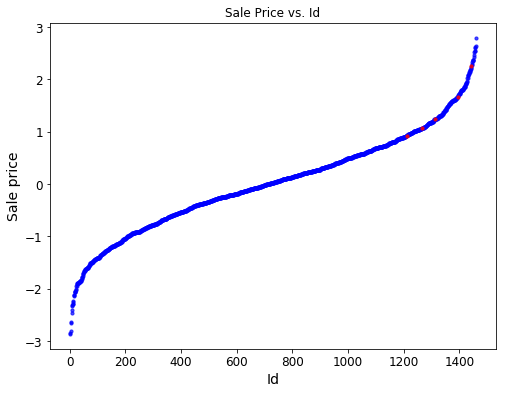

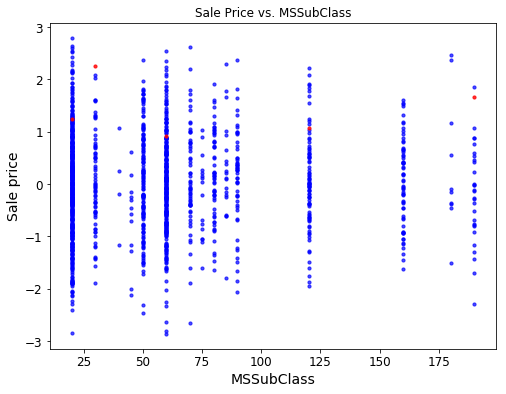

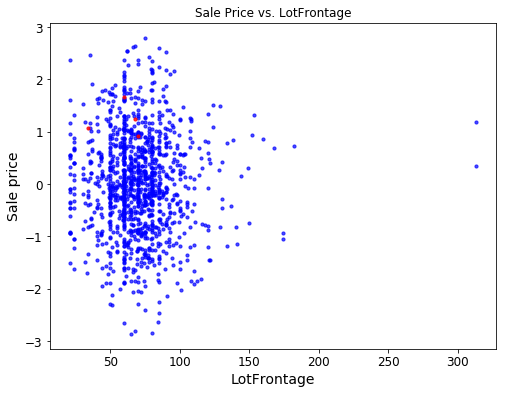

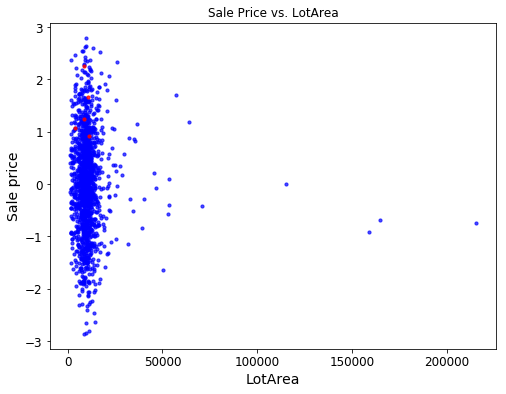

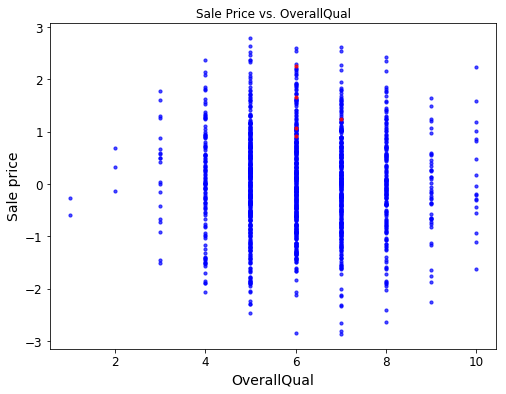

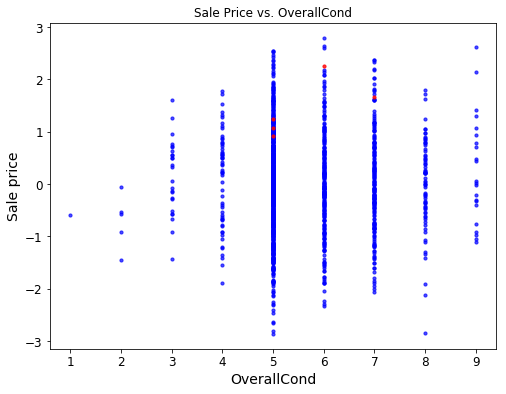

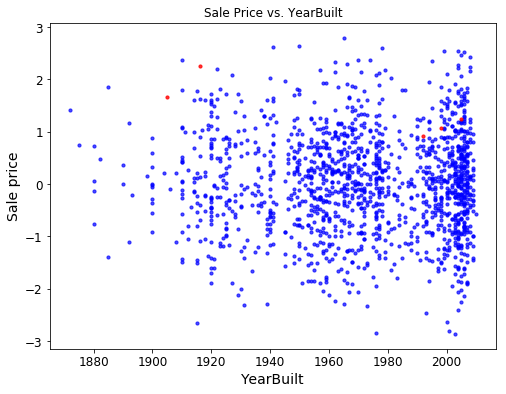

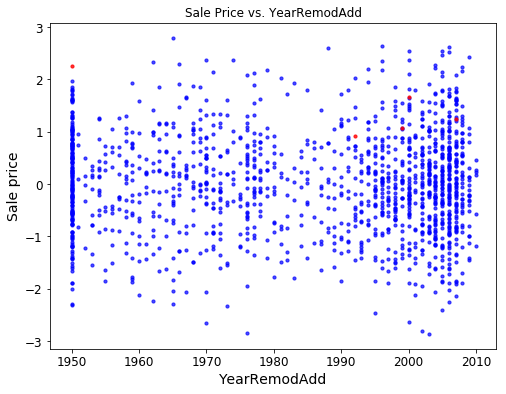

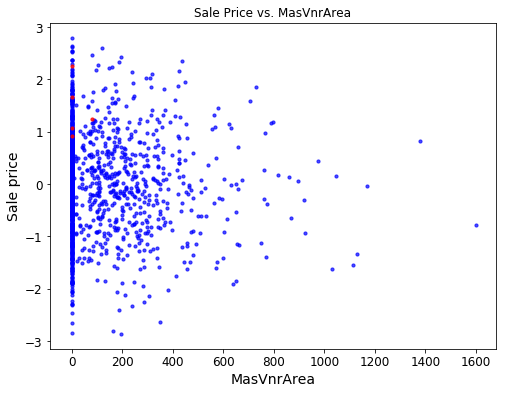

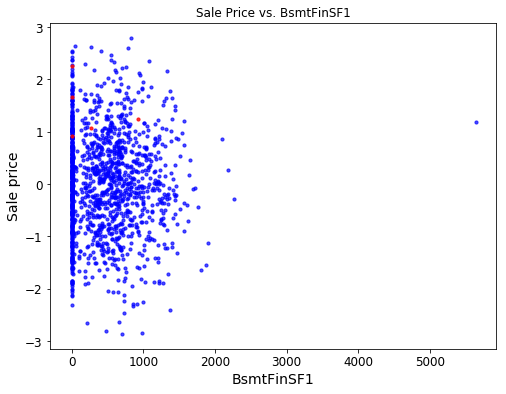

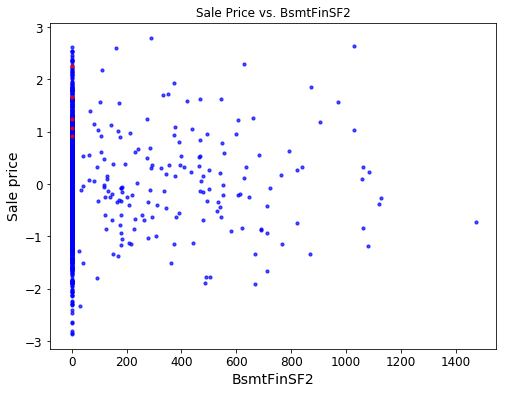

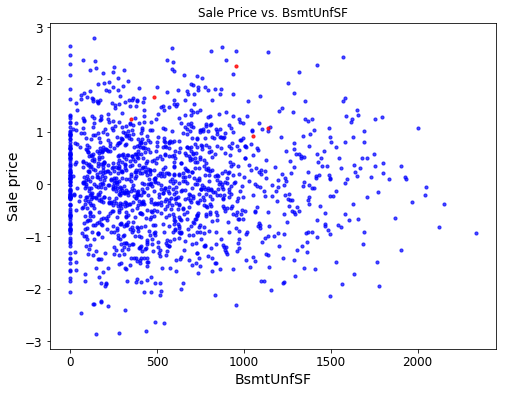

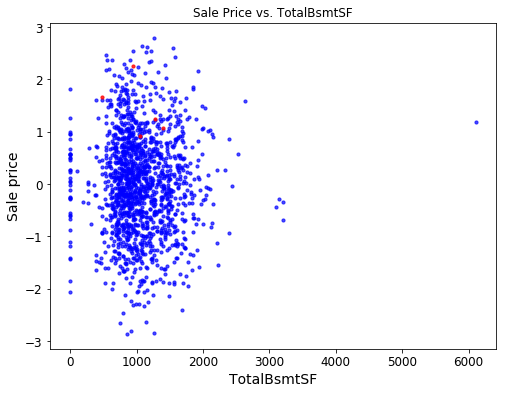

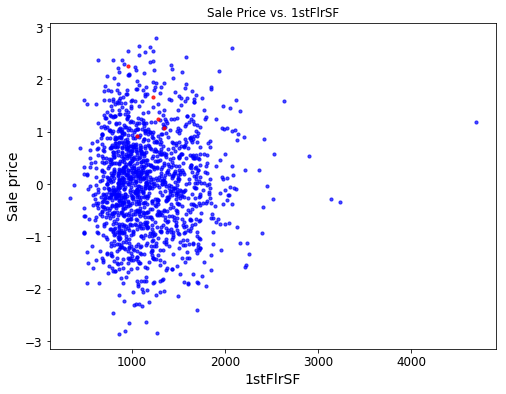

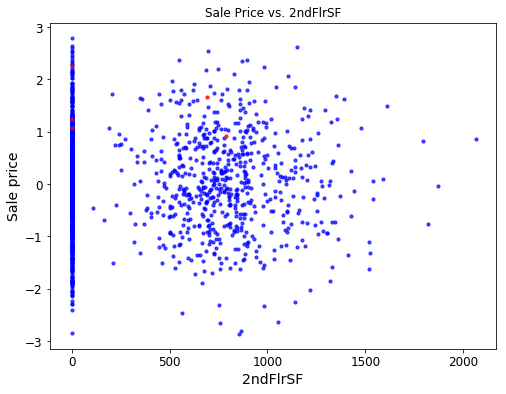

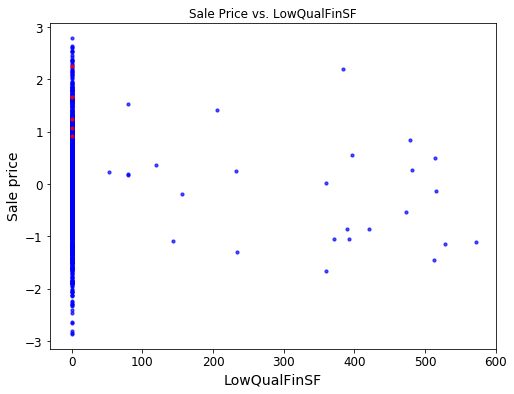

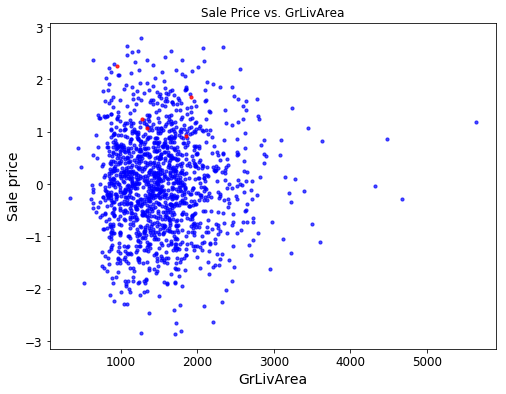

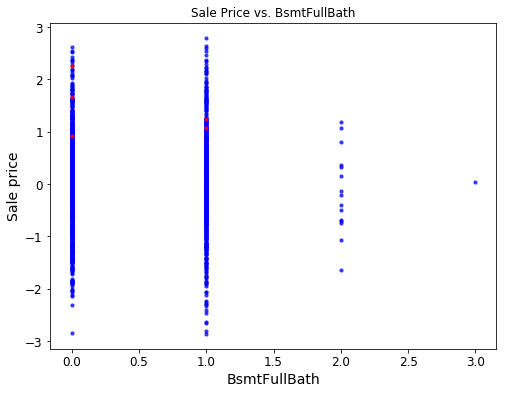

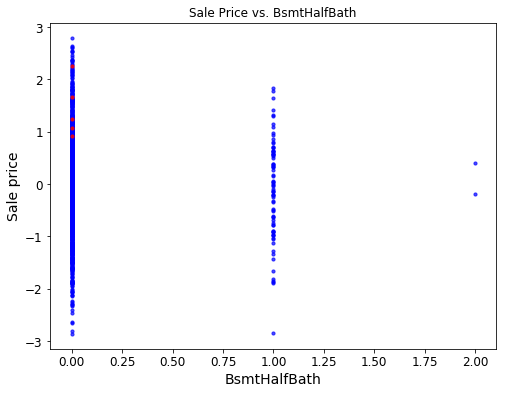

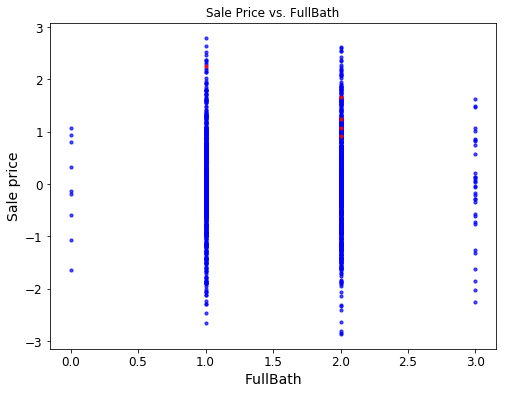

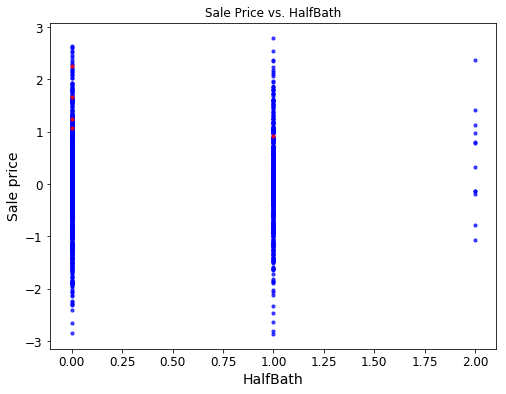

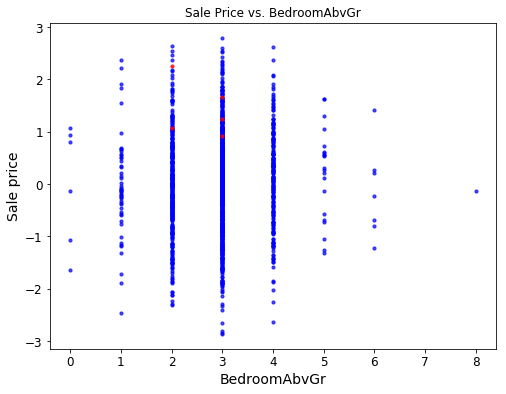

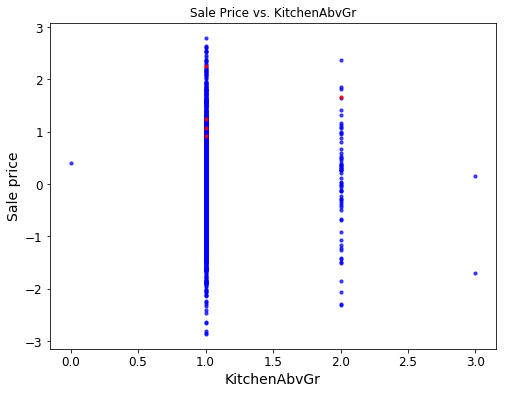

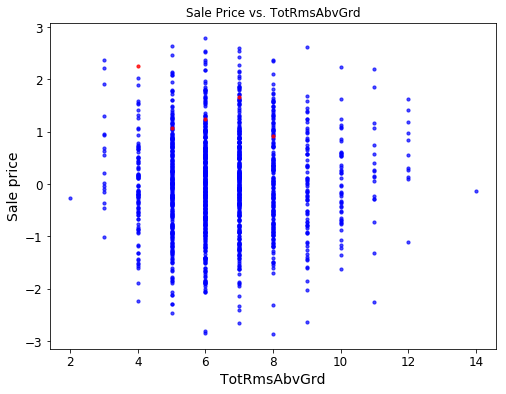

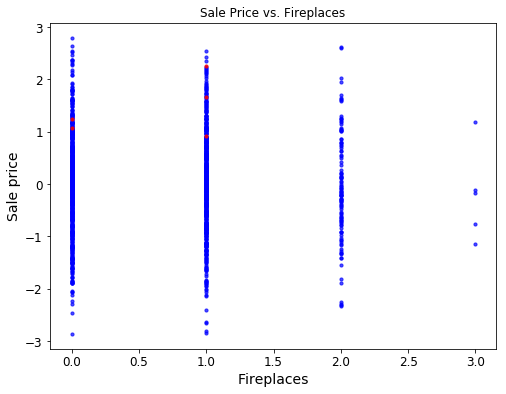

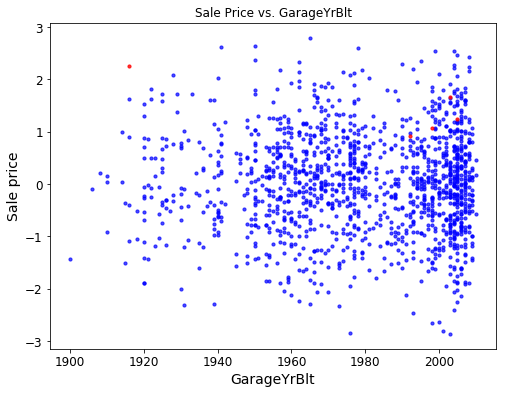

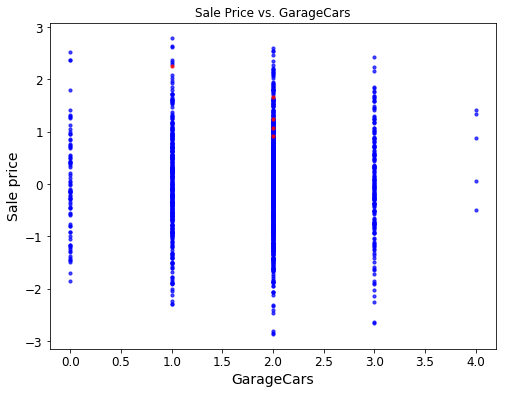

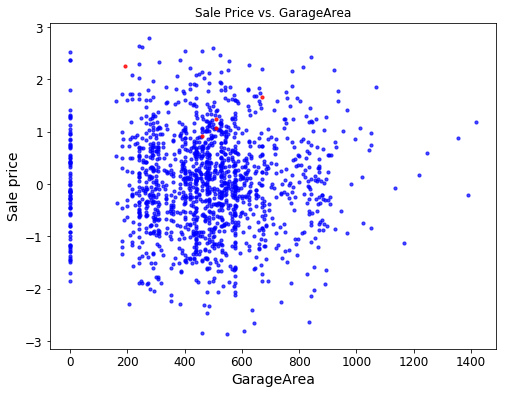

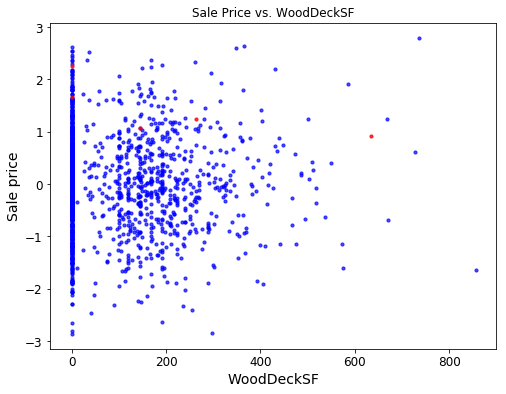

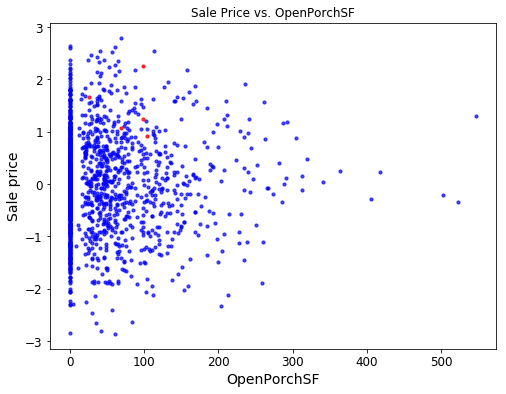

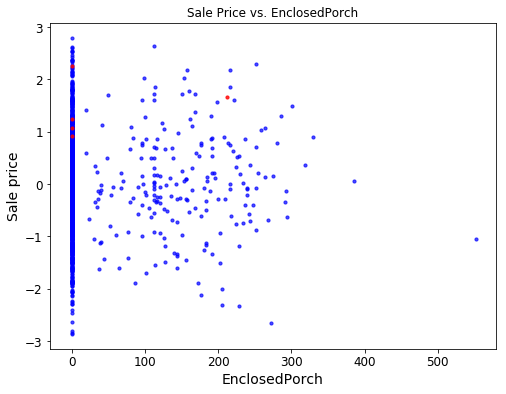

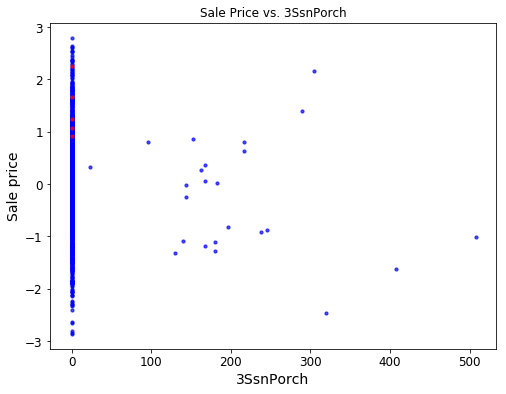

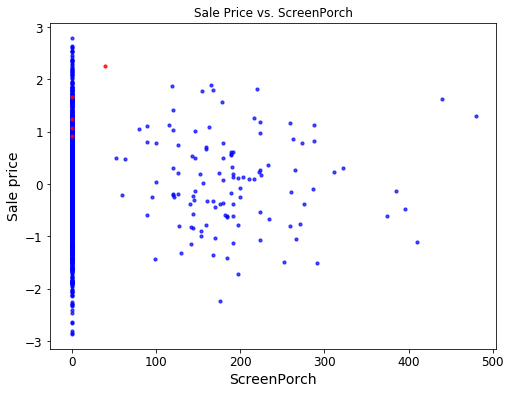

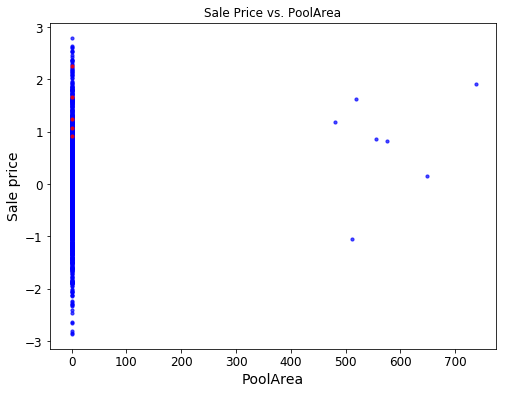

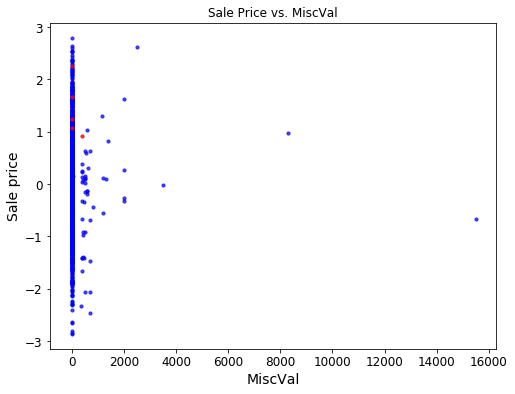

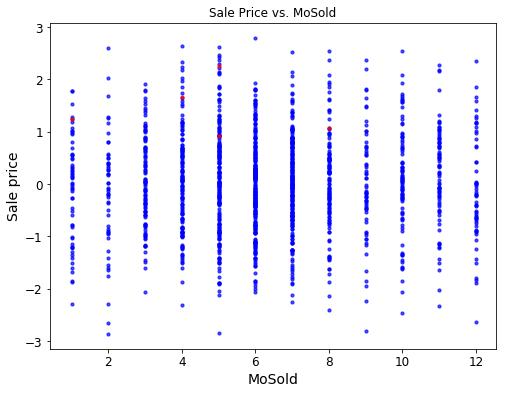

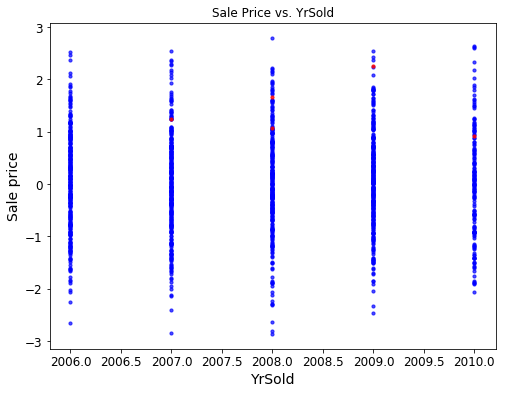

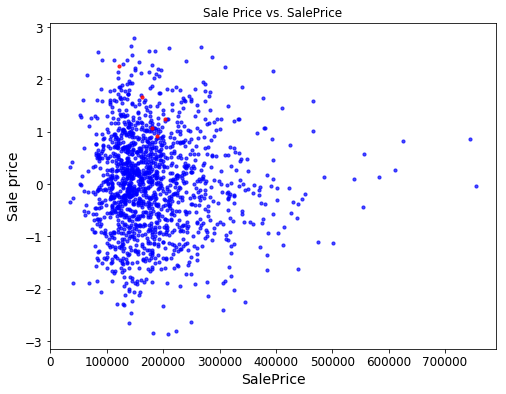

In [9]:
# Will will represent the point with high leverage as per cook theory using the diagonal of the H matrice

def scatterCook(df):
    import matplotlib.pyplot as plt
    import statsmodels.nonparametric.smoothers_lowess as lw
    
    
    #y = housing[:samples]
    #reg = linear_model.LinearRegression()
    #reglin = reg.fit(xtrain, y)
    cookpoints = cook_distance(xtrain, y)
    
    cols = df.columns.tolist()
    ## Loop over the columns and create the scatter plots
    for col in cols:
        
        if(df[col].dtype in [np.int64, np.int32, np.float64]):

            ## Now make the plots
            fig = plt.figure(figsize=(8, 6))
            fig.clf()
            ax = fig.gca()
            plt.scatter(df[col][cookpoints == 0], y[cookpoints == 0], marker='o', color='blue',alpha=0.7,s = 10,label='normal')
            plt.scatter(df[col][cookpoints == 1], y[cookpoints == 1], marker='o', color='red',alpha=0.8,s = 10,label='Cook')

            ax.set_xlabel(col)
            ax.set_ylabel('Sale price')
            ax.set_title('Sale Price vs. ' + col)
            
    return 'Done'

%matplotlib inline
#scatter(train, num_cols)
scatterCook(DataFrame(train))

# Now let's study the residual of the linear regression

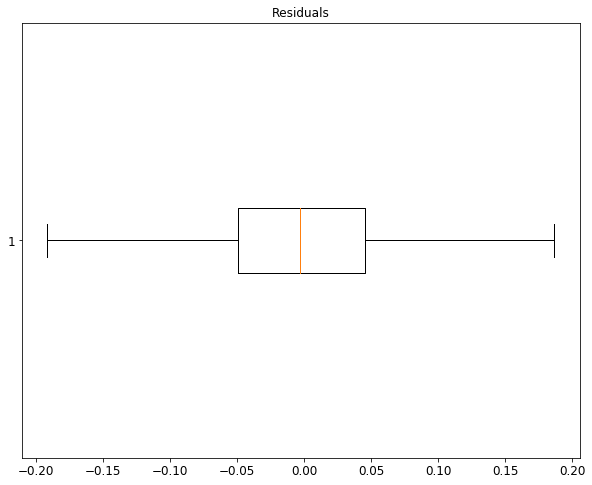

In [10]:
# We use a simple horizontal boxplot of the residual to see outliers

fig = plt.figure(figsize=(10, 8))
plt.boxplot(pred['resid_log'],0, '', 0)
#plt.set_ylabel('resid ')
plt.title('Residuals') ;


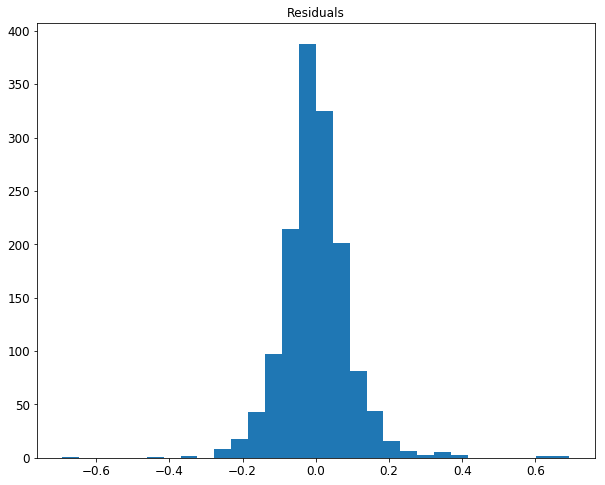

In [11]:
# Now let's plot the histogram

fig = plt.figure(figsize=(10, 8))
plt.hist(pred['resid_log'],bins = 30)
#plt.set_ylabel('resid ')
plt.title('Residuals') ;

C:\Users\BQUIDET\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


'Done'

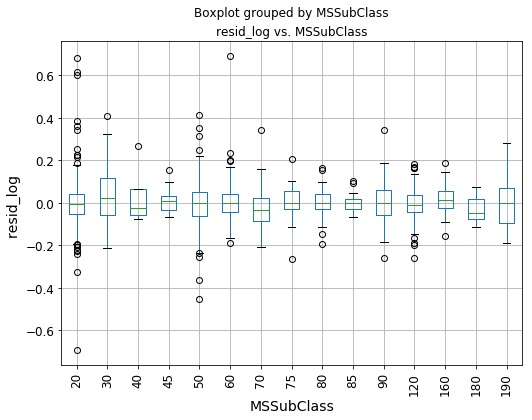

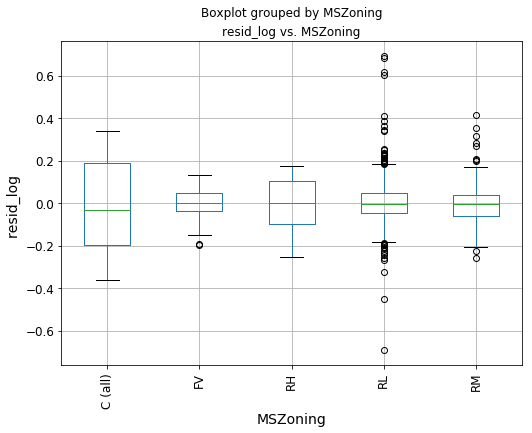

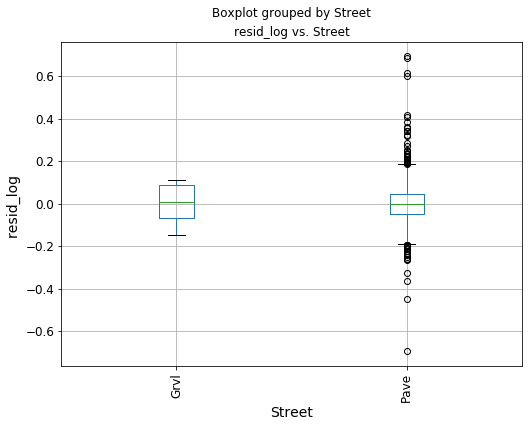

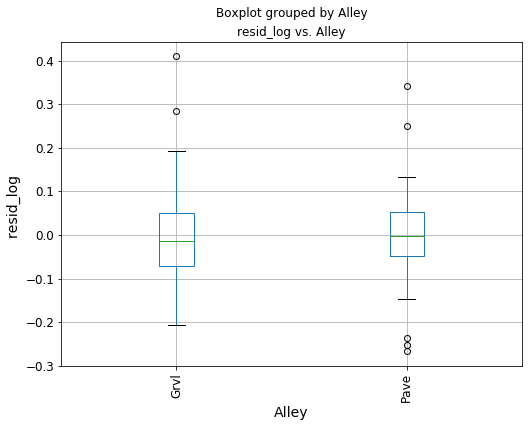

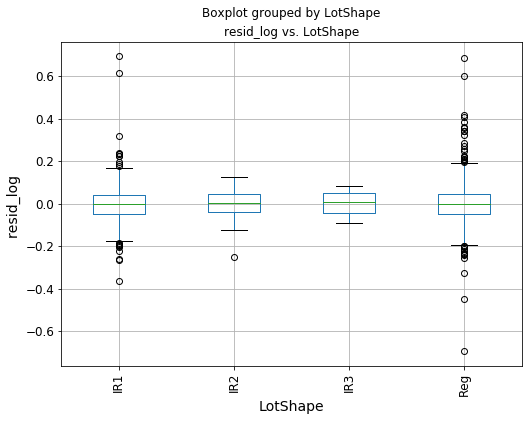

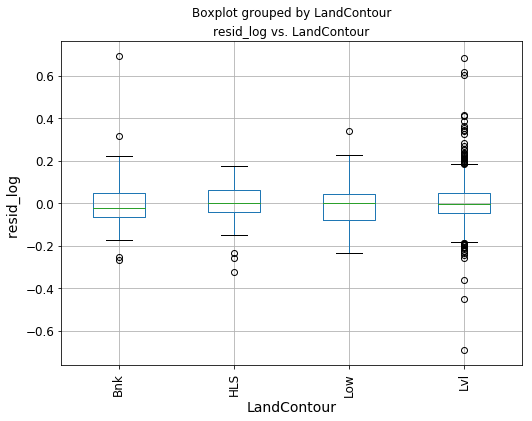

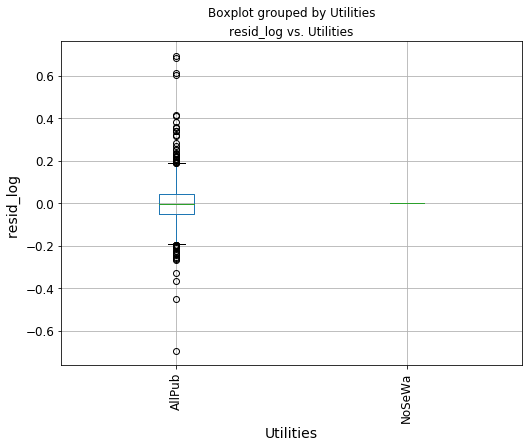

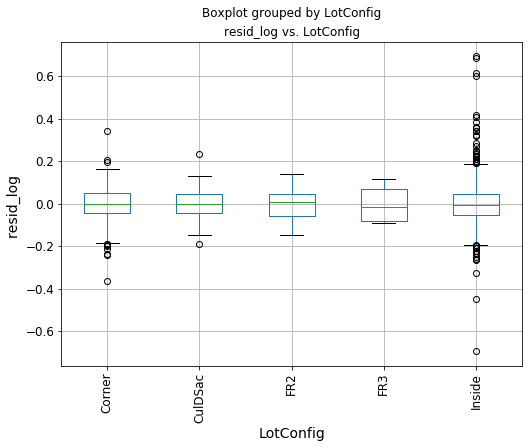

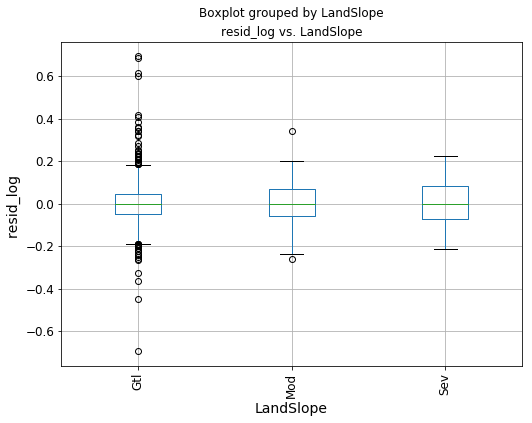

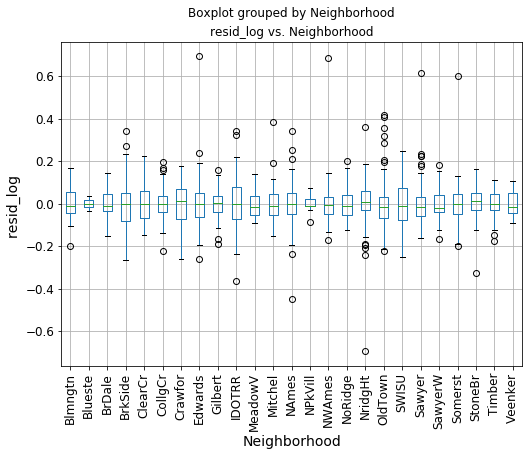

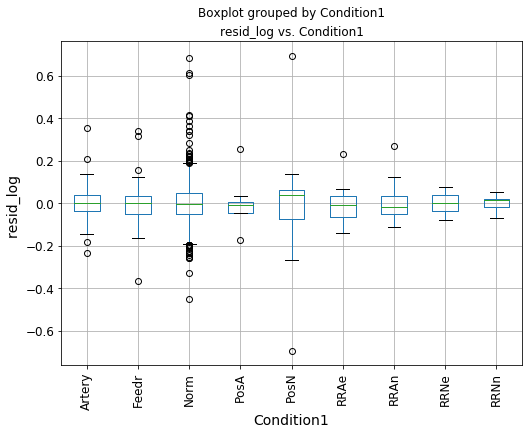

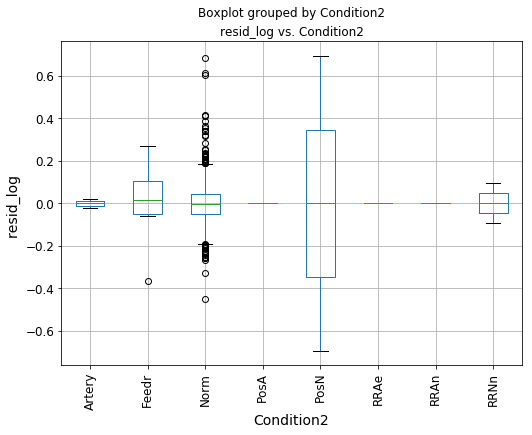

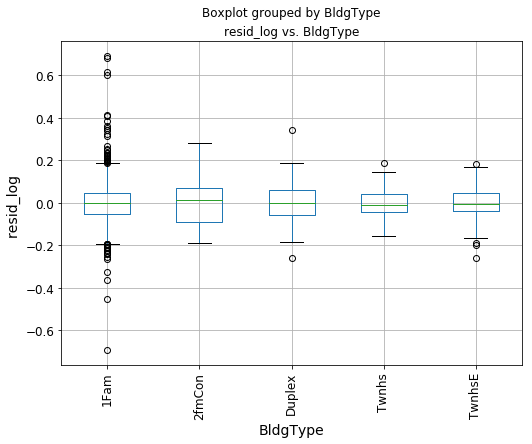

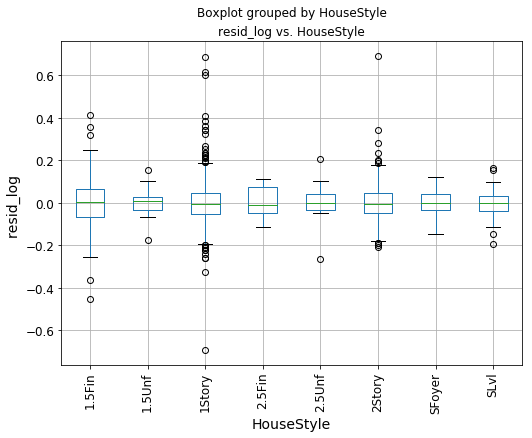

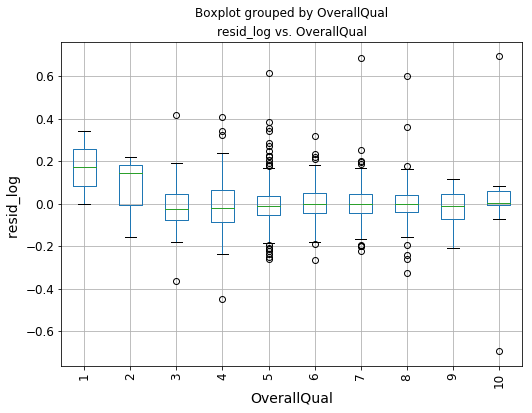

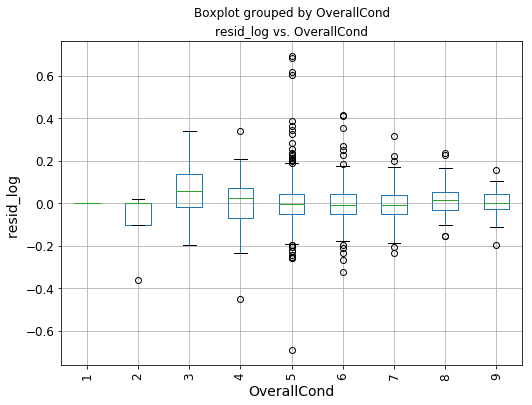

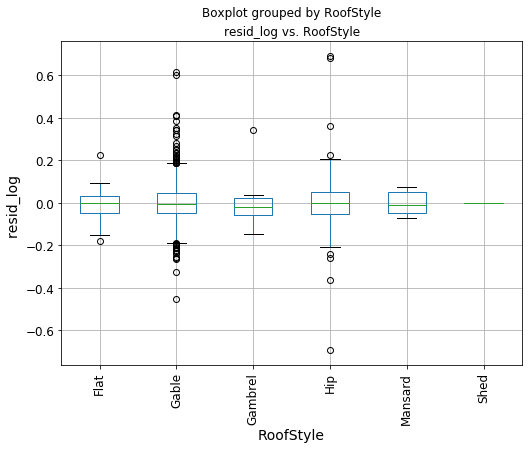

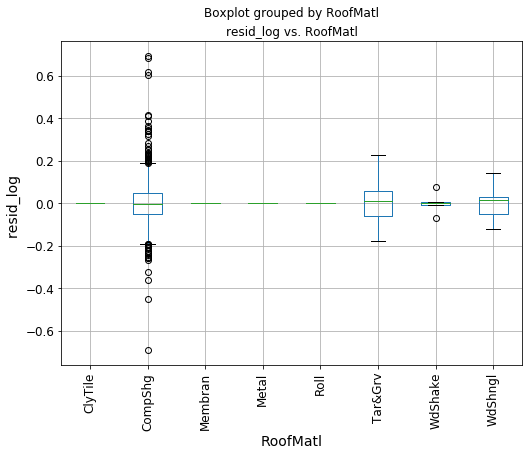

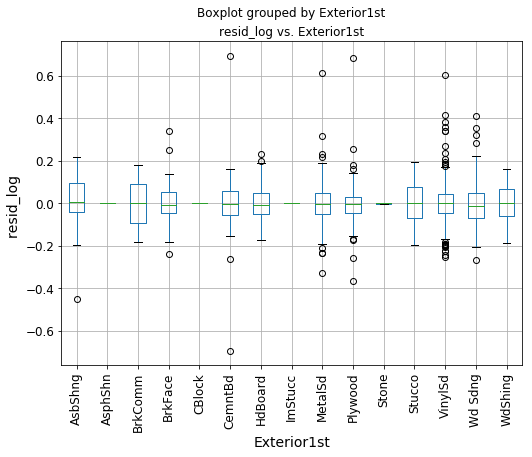

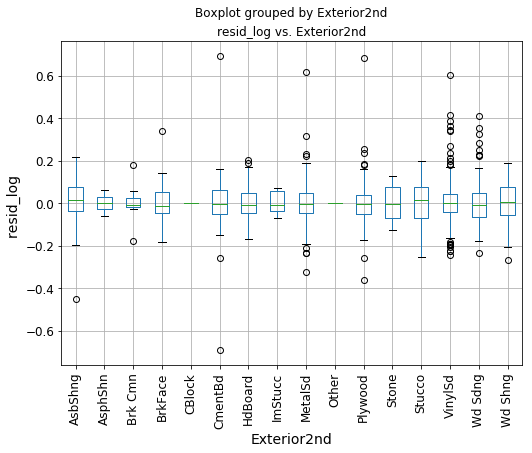

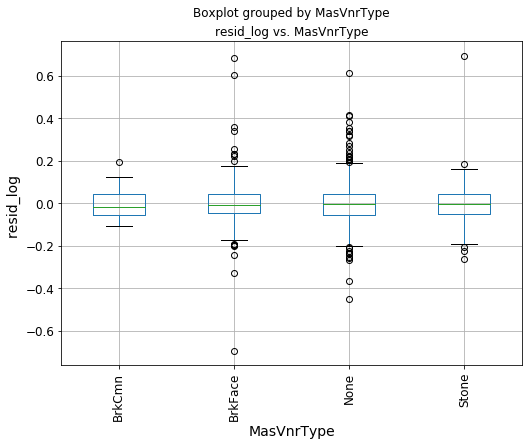

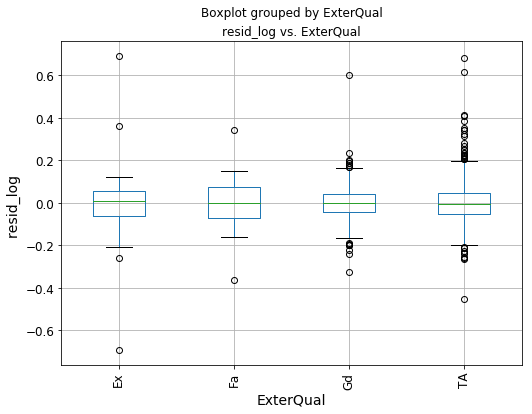

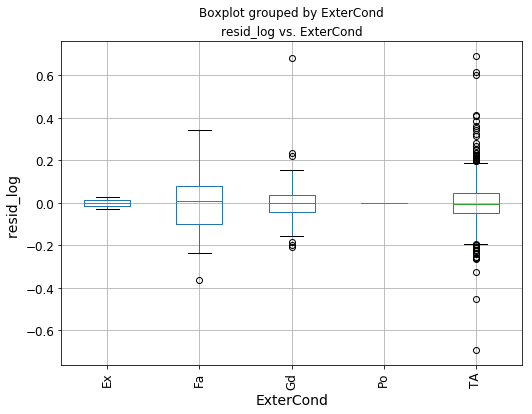

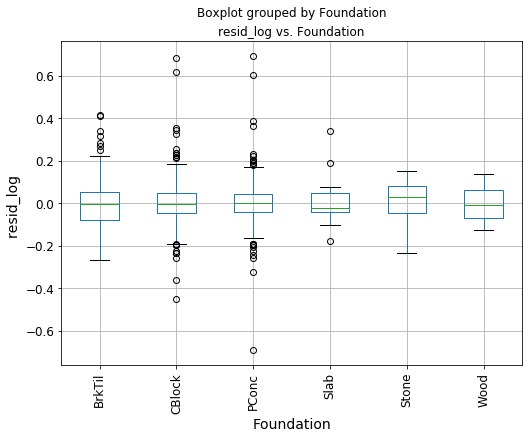

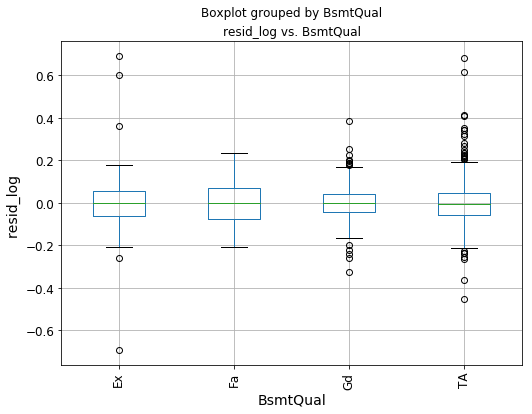

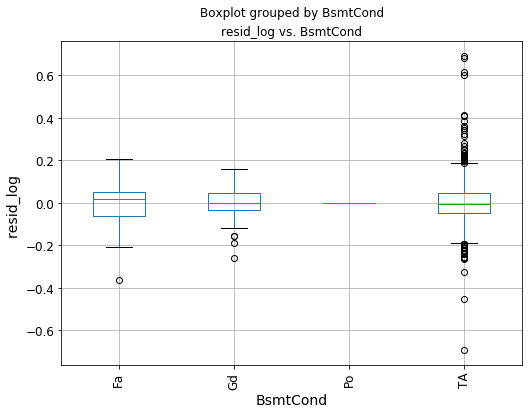

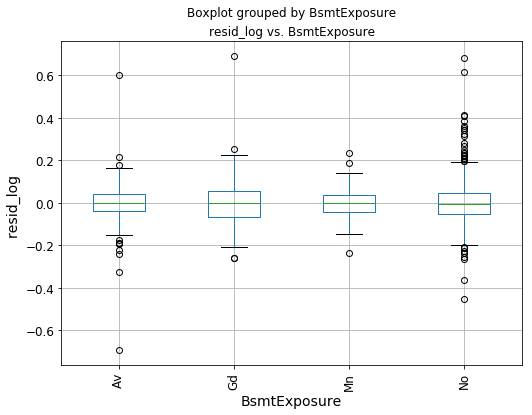

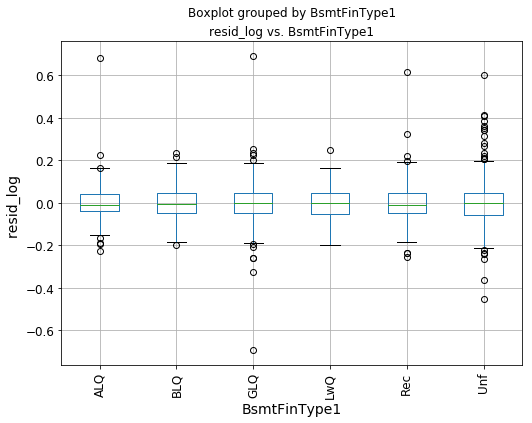

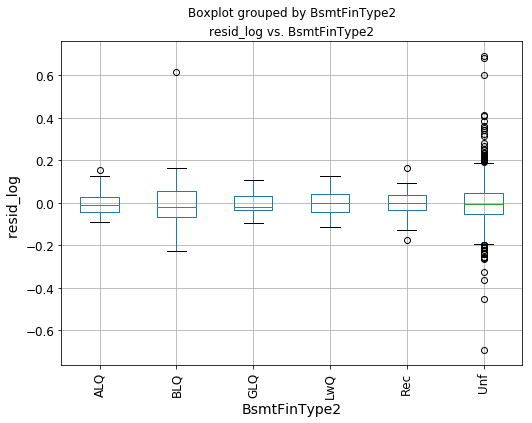

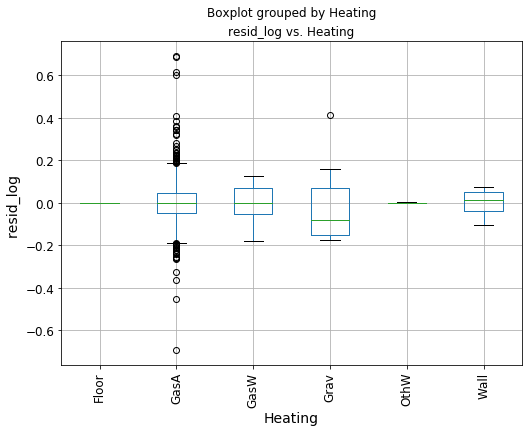

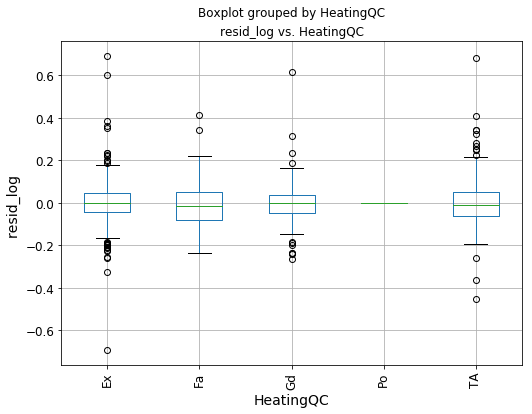

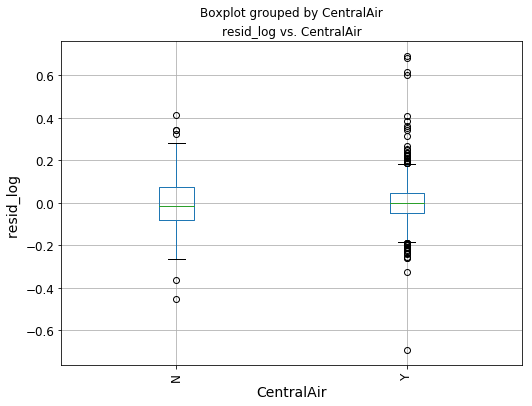

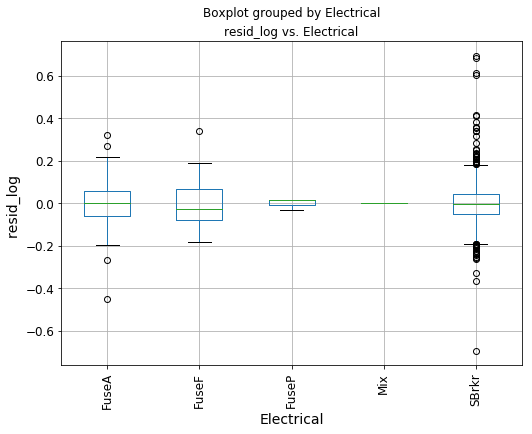

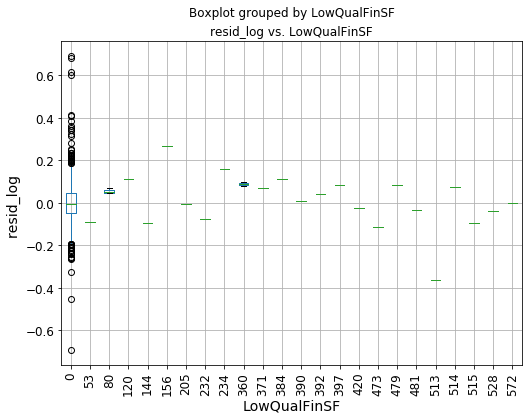

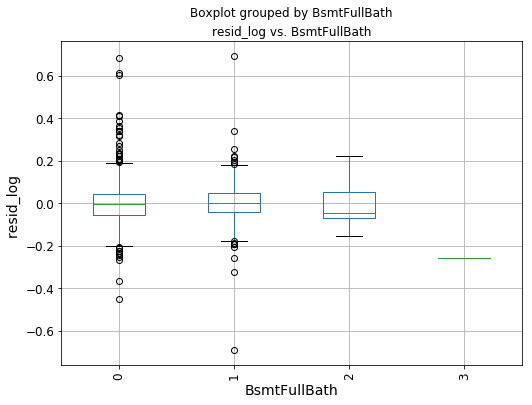

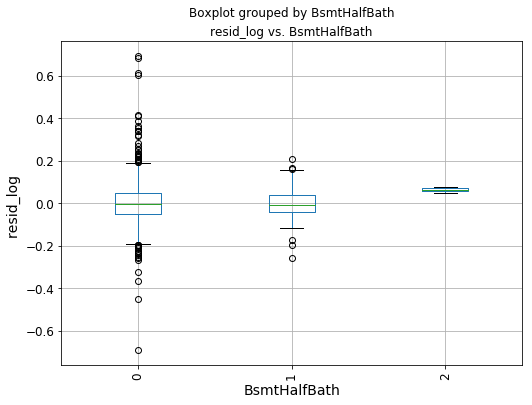

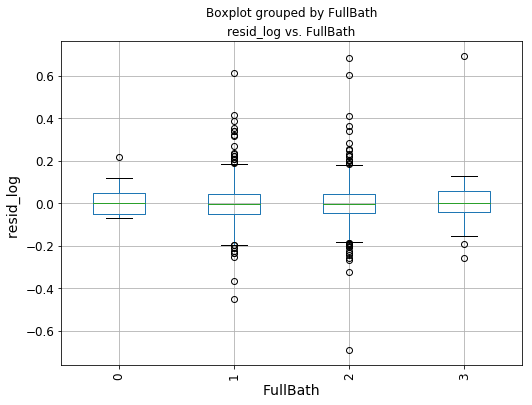

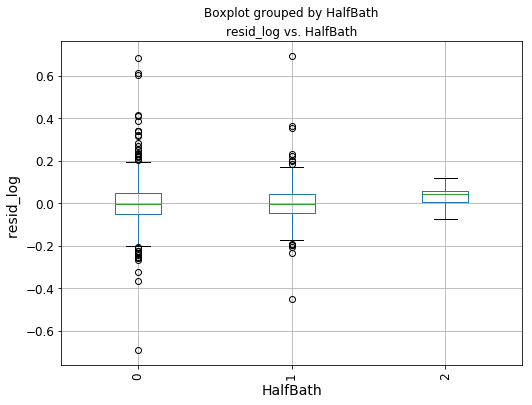

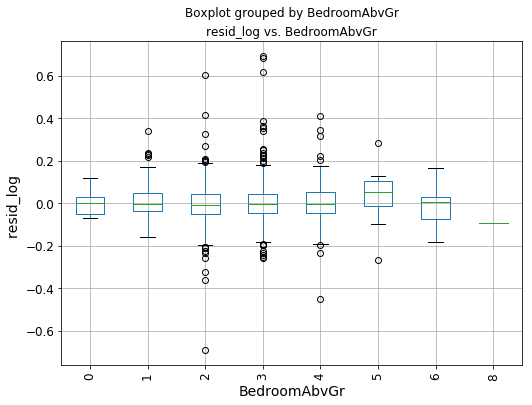

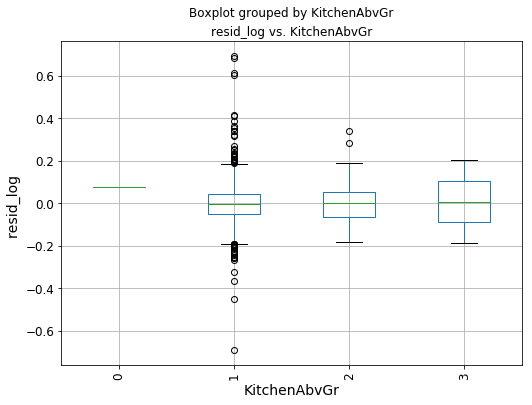

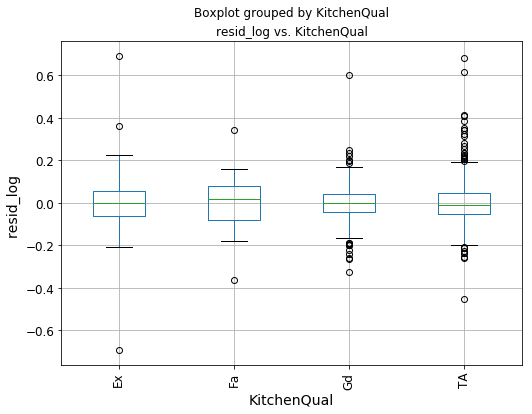

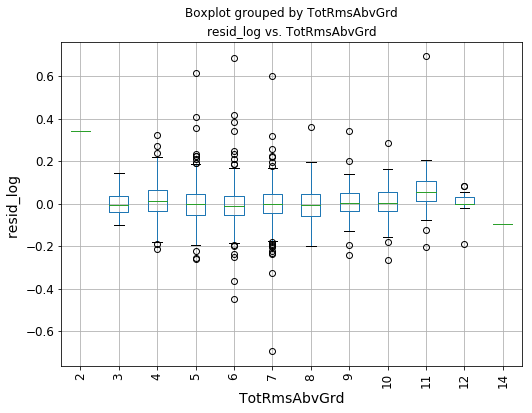

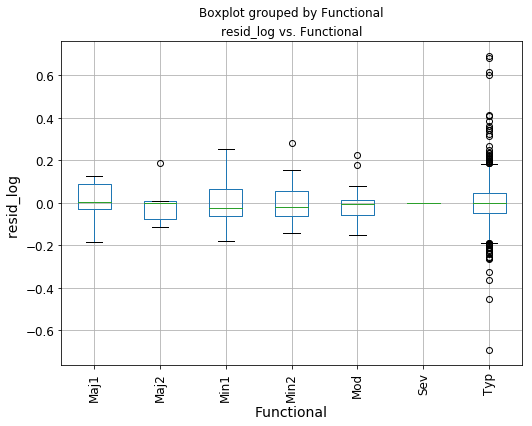

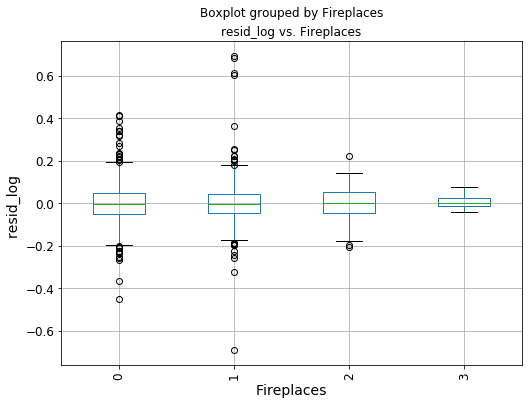

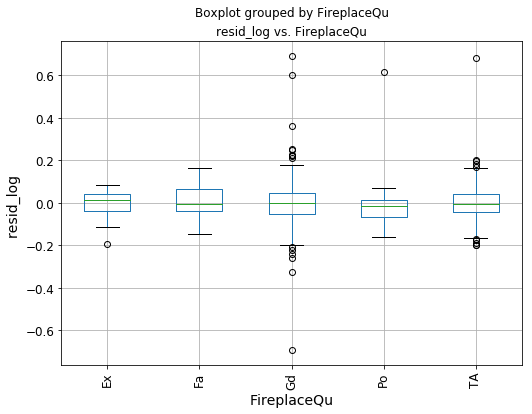

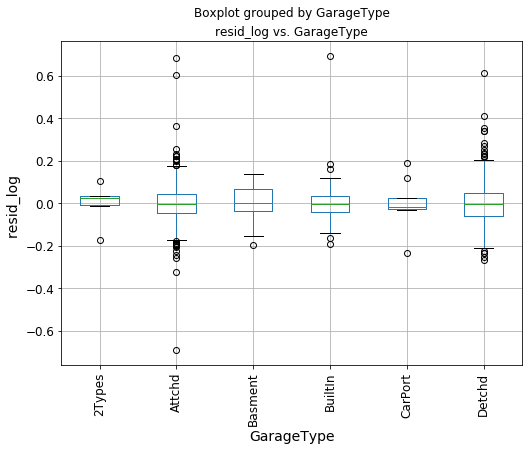

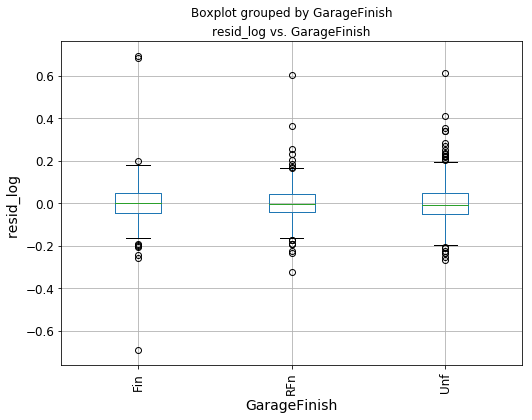

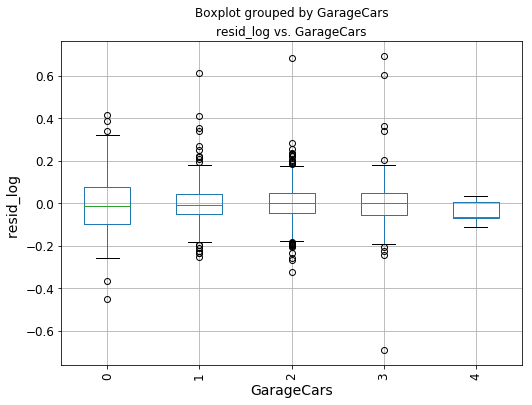

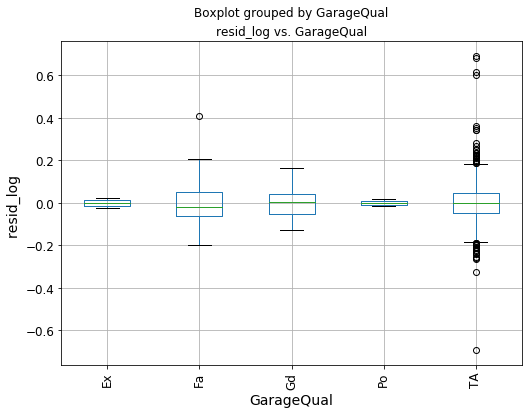

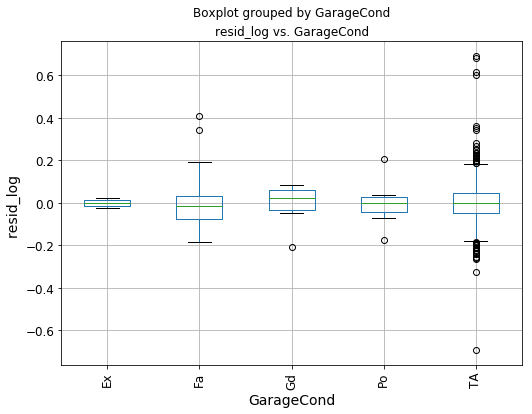

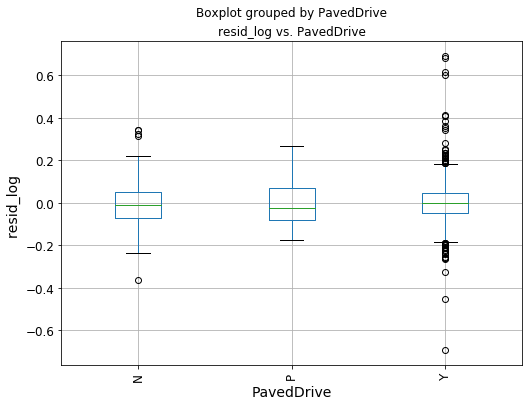

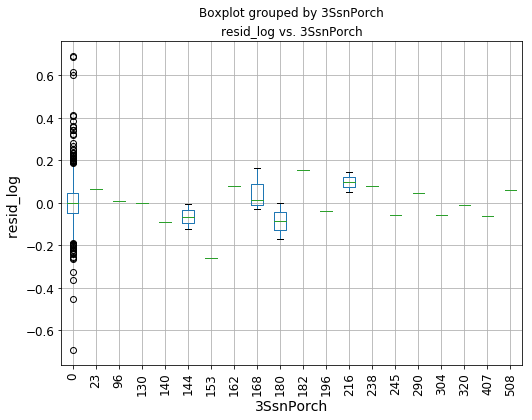

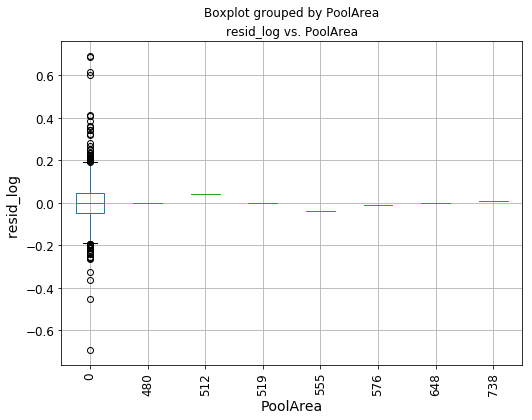

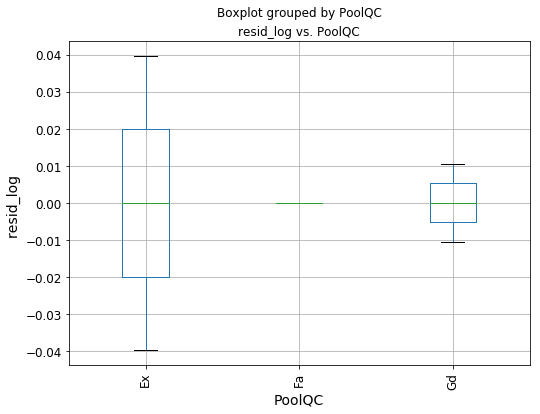

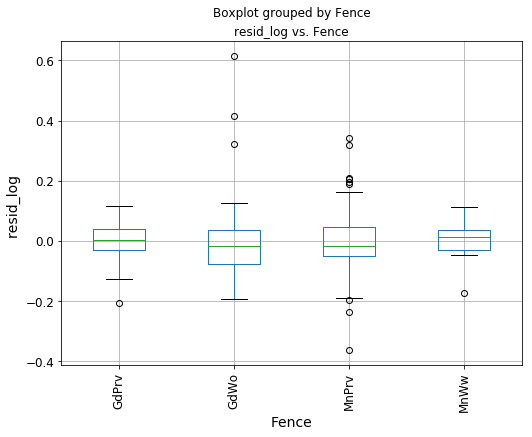

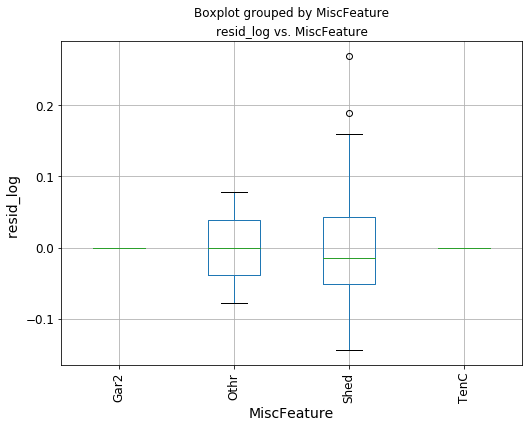

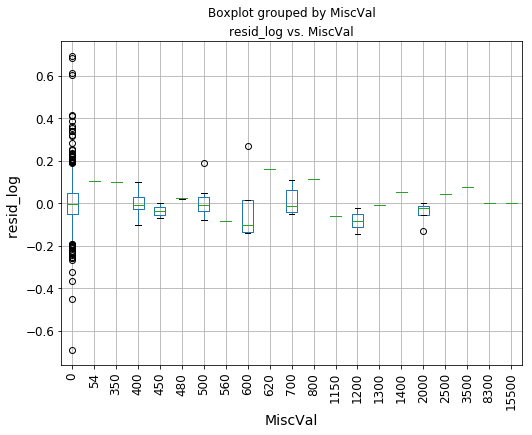

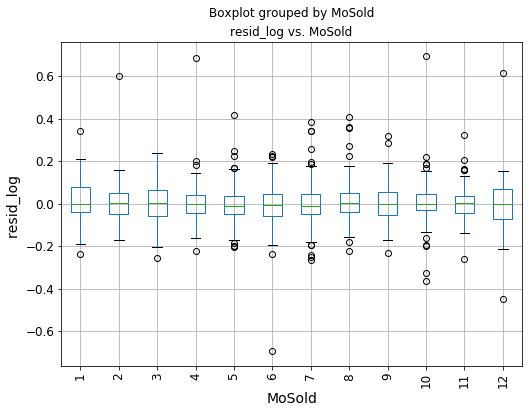

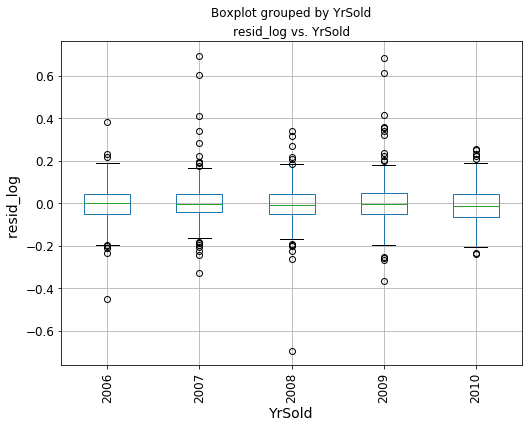

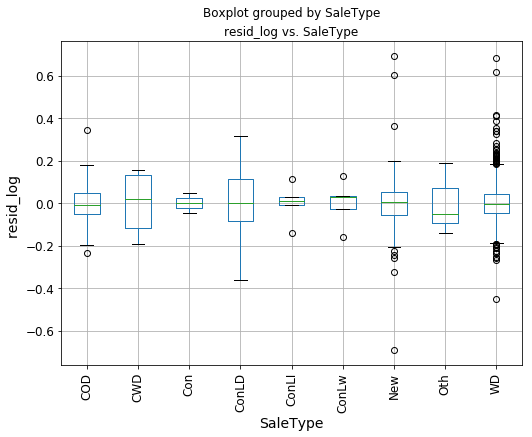

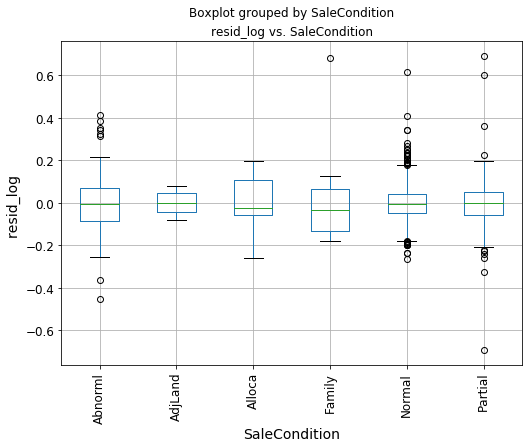

In [12]:
# Now let's visualize the error boxplot for each categorical feature
def errors_box(df):
    import matplotlib.pyplot as plt
    
    ## Loop over the columns and create the box plots
    cols = df.columns.tolist()
    for col in cols:
        
        if(df[col].dtype not in [np.int64, np.int32, np.float64] or len(set(df[col]))<40):
            fig = plt.figure(figsize=(8, 6))
            fig.clf()
            ax = fig.gca()
            df.boxplot(column = 'resid_log', by = col, ax = ax)
            ax.set_xlabel(col)
            plt.xticks(rotation=90)
            ax.set_ylabel('resid_log ')
            ax.set_title('resid_log vs. ' + col) 
            #ax.set_xticklabels( rotation=45 )
    return 'Done'

# When above zero : we over estimate real price with out model, when below , we underestimate real price
train_box = pd.concat([train, pred['resid_log']], axis=1, join='inner')
errors_box(train_box)

By Looking at the boxplots , we don't see any category that we under not over estimate as no noticeable box is
located far from 0 value. Maybe we can say that OverallQual is a factor we overestimate for bad condition real estates.

For Neighborhood we see that all boxes look symetric. 

In [13]:
# Let's take the point for which error is in the tales, which absolute value is above 95 and 99% of the error dist

perc_99_pct = pred['resid_log'].quantile( 0.99)
perc_95_pct = pred['resid_log'].quantile( 0.95)


# Let's redefine the training examples
housing_prepared = full_pipeline.fit_transform(housing)
xtrain = housing_prepared[:samples]
y = np.log1p(train[label_col])

inliers = np.abs(pred['resid_log'])< perc_95_pct
xtrain_no_outliers = xtrain[inliers]
y_no_outliers = y[inliers]



In [14]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression

param_distribs = {
        'fit_intercept': [True, False],
        'normalize': [True, False],
    }

lin_reg = LinearRegression()
rnd_search = RandomizedSearchCV(lin_reg, param_distributions=param_distribs,
                                n_iter=4, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, n_jobs=4, random_state=42)

# We need to redefine xtrain for each model to be the training set from preparation pipeline

rnd_search.fit(xtrain_no_outliers, y_no_outliers)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    3.9s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
          fit_params=None, iid=True, n_iter=4, n_jobs=4,
          param_distributions={'fit_intercept': [True, False], 'normalize': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=2)

In [15]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

def display_scores_params(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    print("Best params:", rnd_search.best_params_)
    
display_scores_params(rmse)

Scores: 0.12226007984628054
Mean: 0.12226007984628054
Standard deviation: 0.0
Best params: {'normalize': False, 'fit_intercept': True}


C:\Users\BQUIDET\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


'Done'

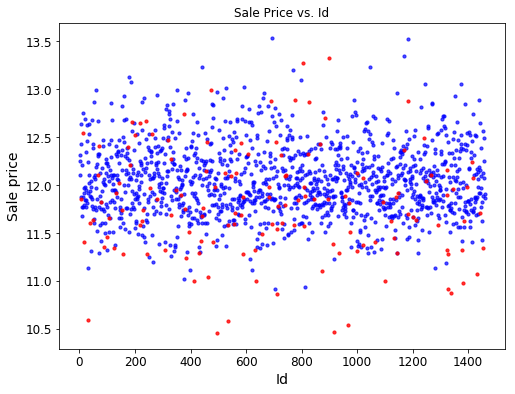

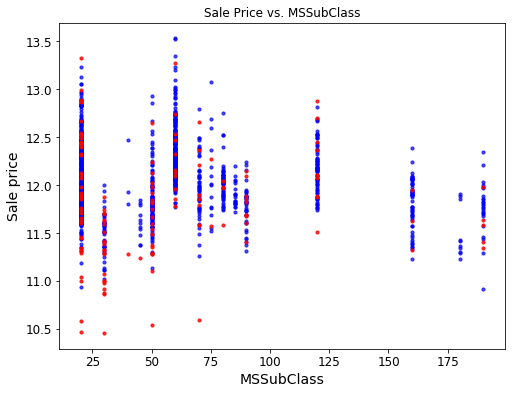

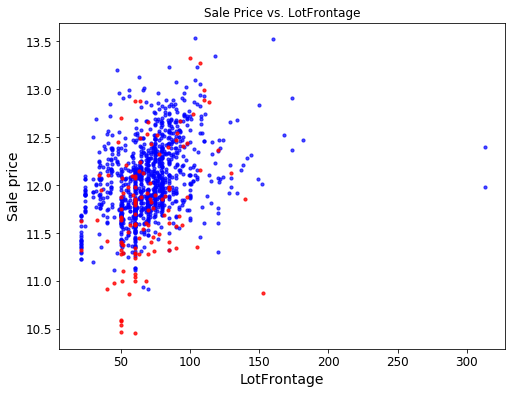

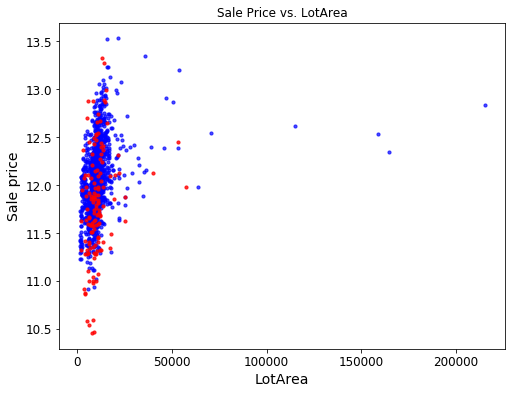

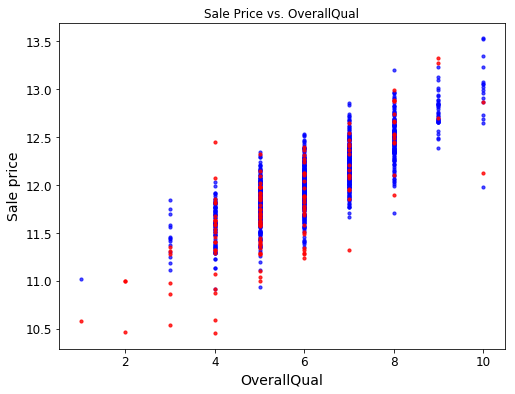

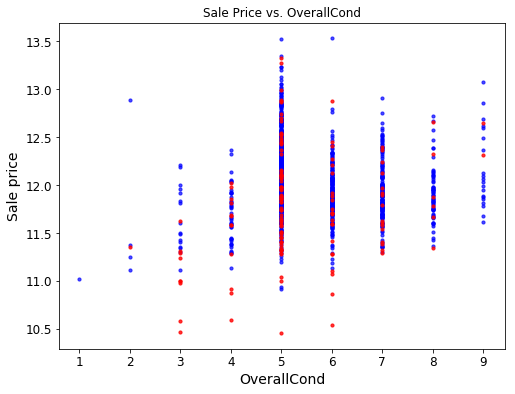

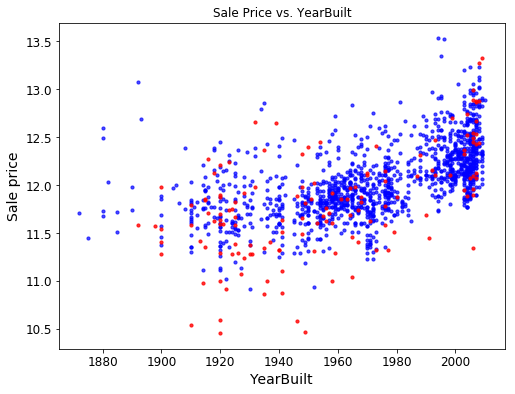

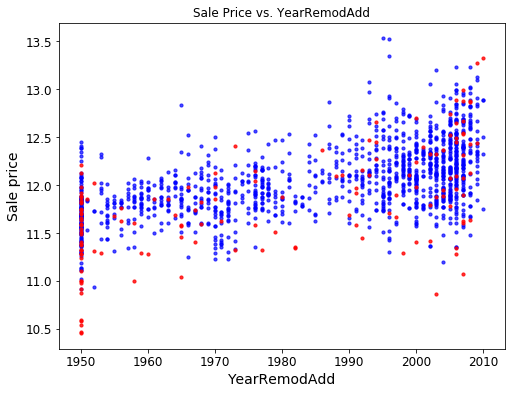

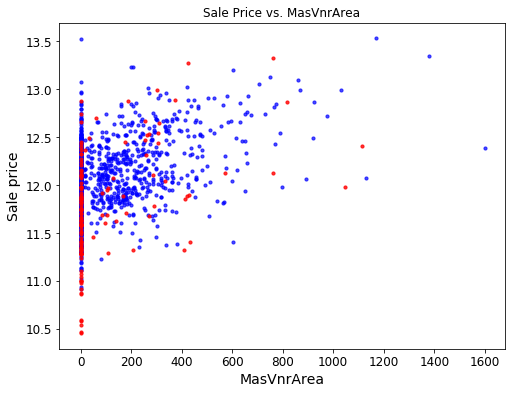

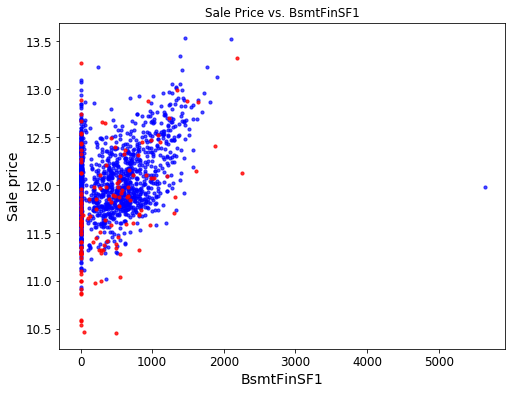

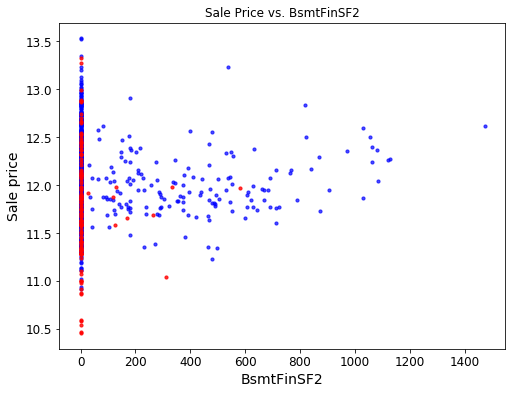

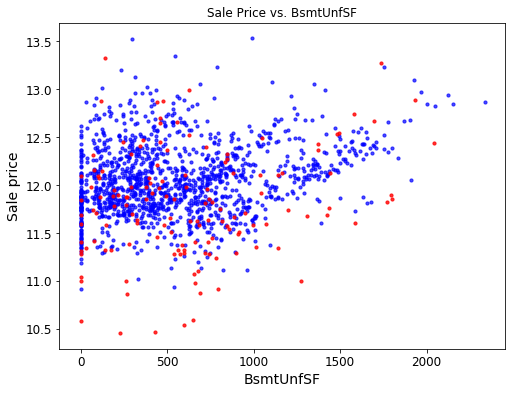

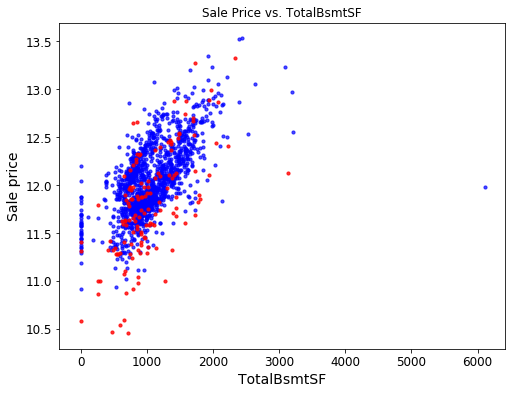

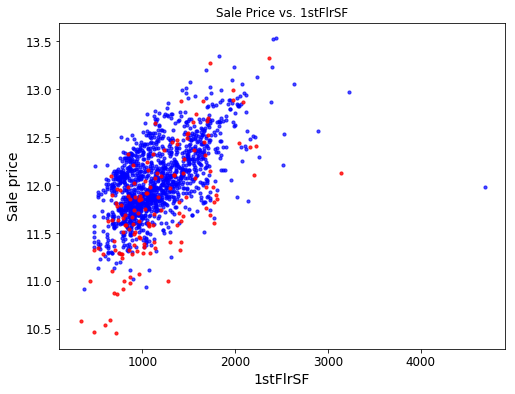

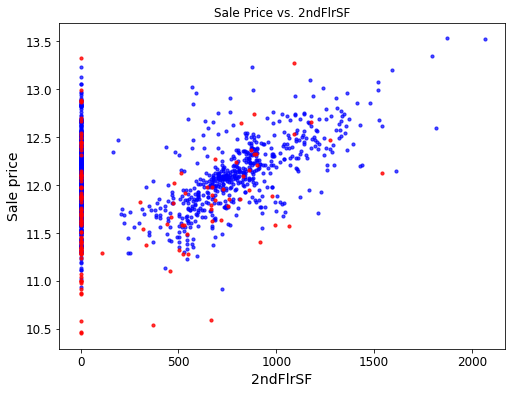

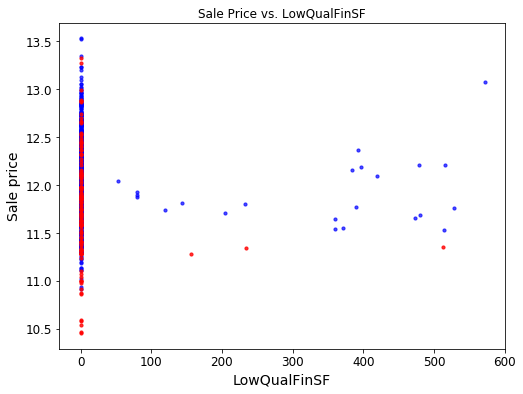

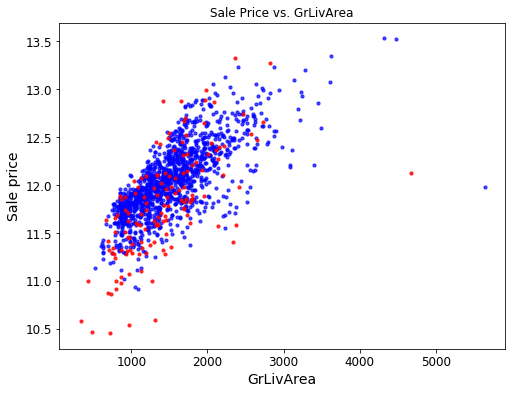

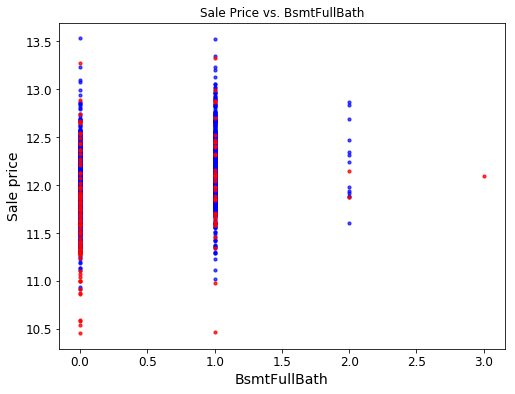

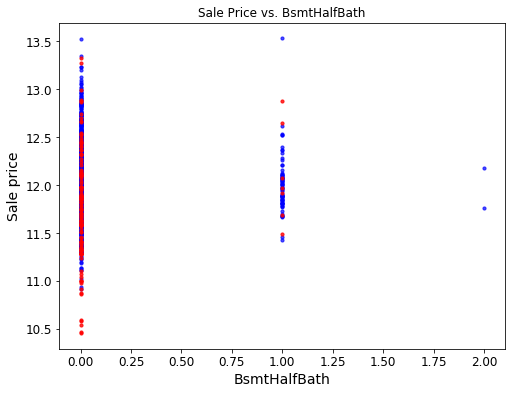

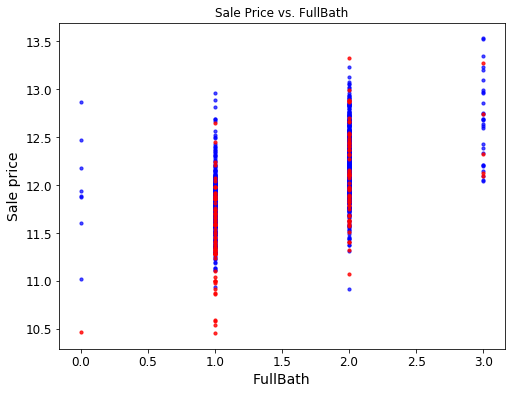

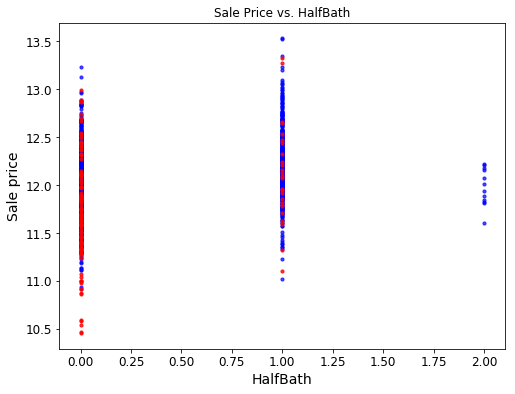

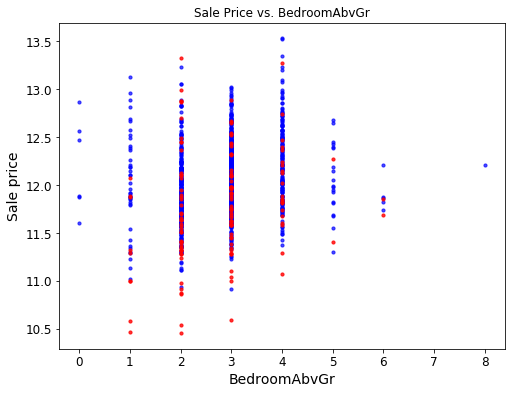

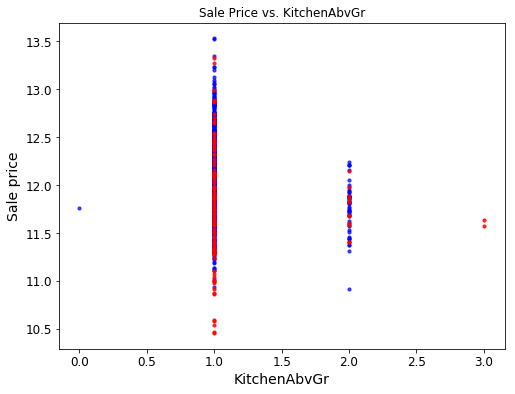

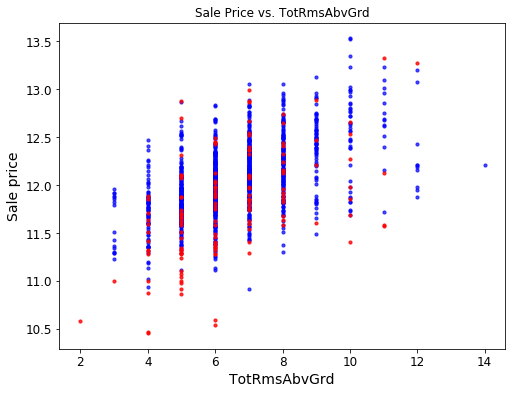

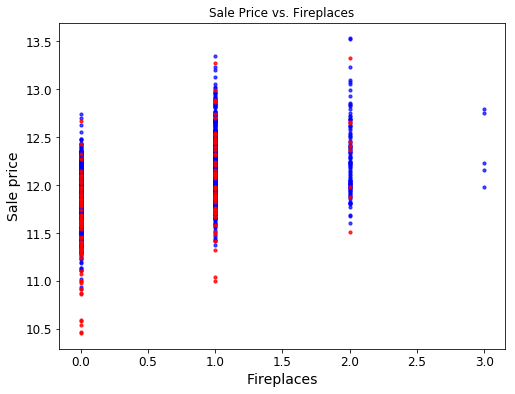

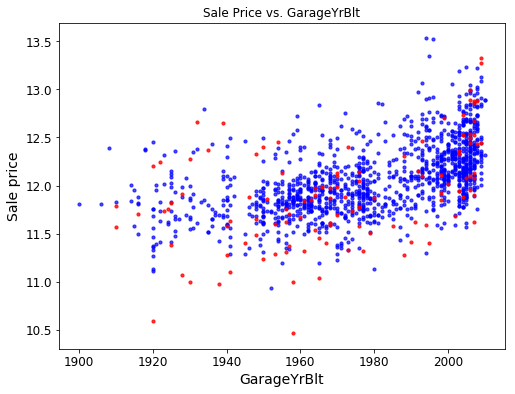

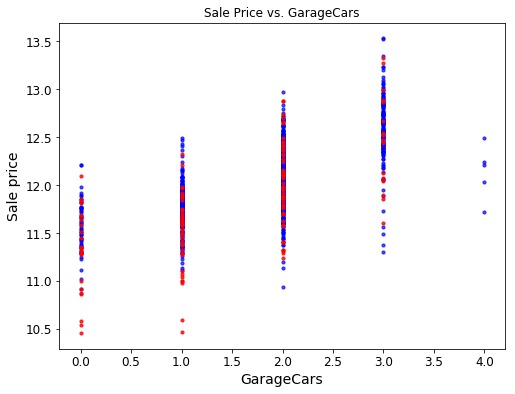

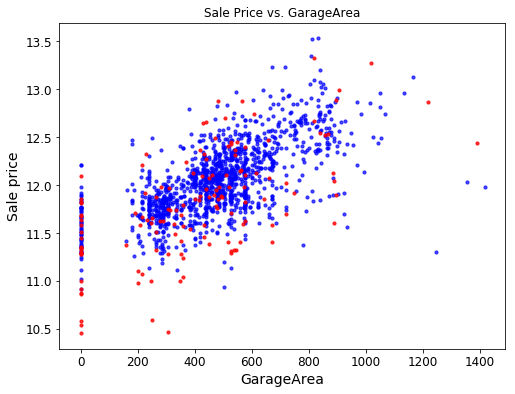

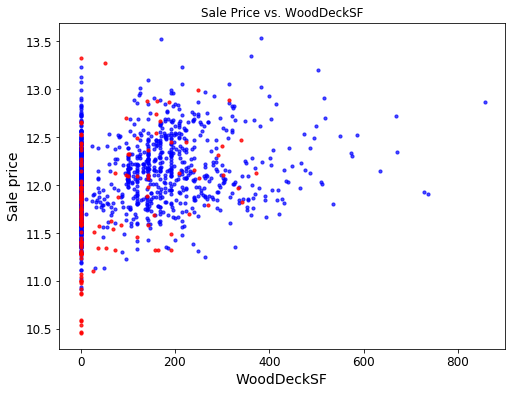

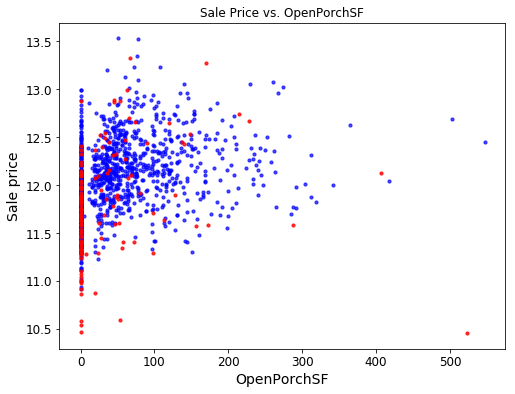

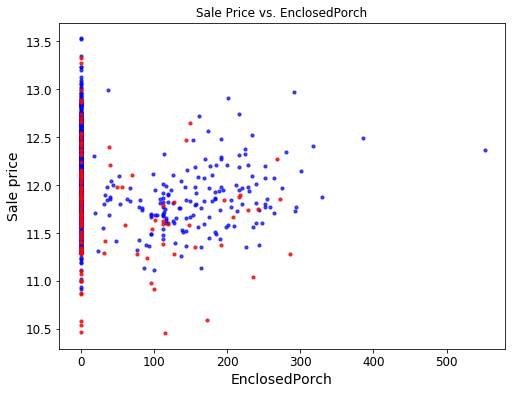

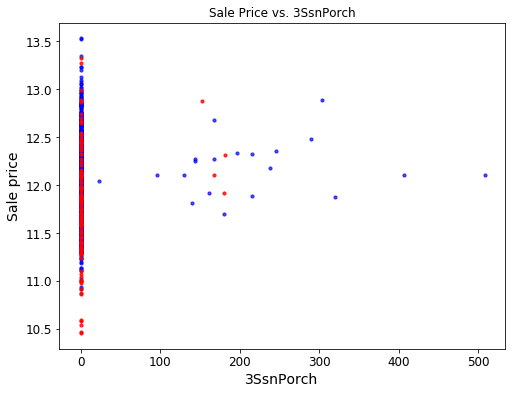

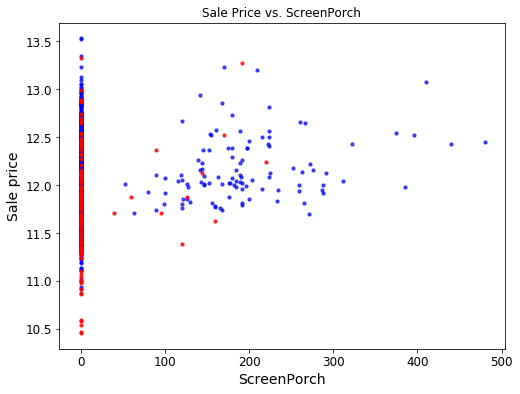

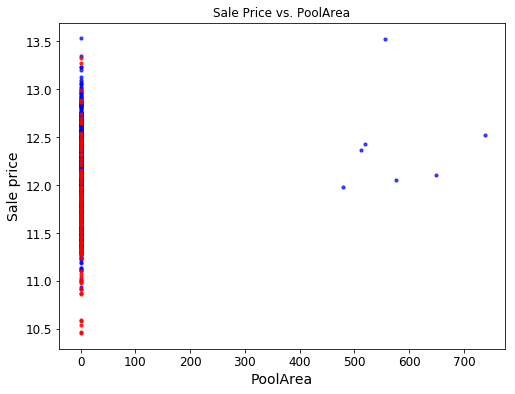

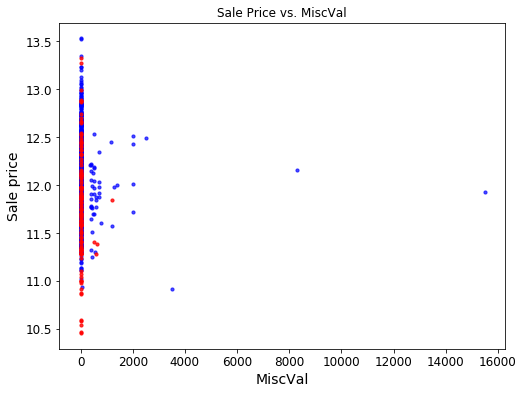

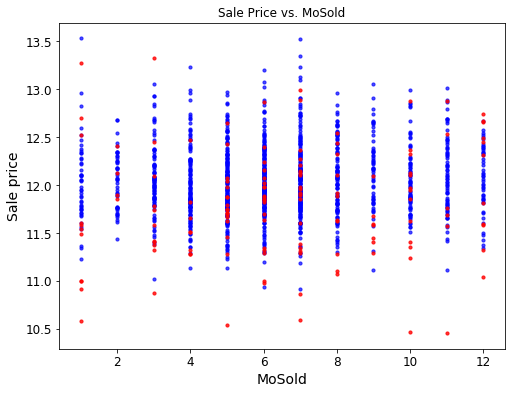

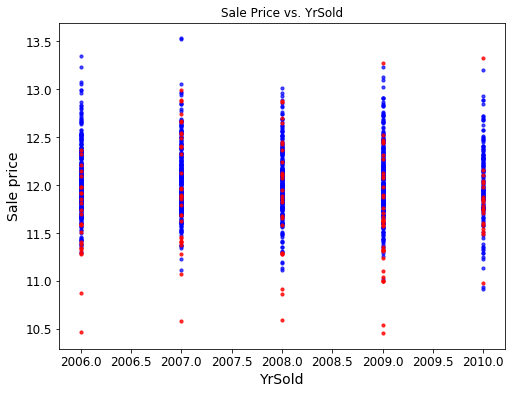

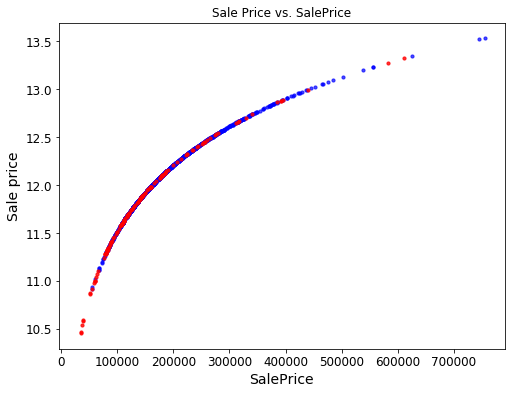

In [16]:
# Let's see the error points according to each numerical value in a scatter plot

def scatter_outliers(df):
    import matplotlib.pyplot as plt
    
    #y = housing[:samples]
    #reg = linear_model.LinearRegression()
    #reglin = reg.fit(xtrain, y)
    outliers = np.abs(pred['resid_log'])> perc_95_pct
    
    cols = df.columns.tolist()
    ## Loop over the columns and create the scatter plots
    for col in cols:
        
        if(df[col].dtype in [np.int64, np.int32, np.float64]):

            ## Now make the plots
            fig = plt.figure(figsize=(8, 6))
            fig.clf()
            ax = fig.gca()
            plt.scatter(df[col][outliers == 0], y[outliers == 0], marker='o', color='blue',alpha=0.7,s = 10,label='normal')
            plt.scatter(df[col][outliers == 1], y[outliers == 1], marker='o', color='red',alpha=0.8,s = 10,label='Outliers')

            ax.set_xlabel(col)
            ax.set_ylabel('Sale price')
            ax.set_title('Sale Price vs. ' + col)
            
    return 'Done'

%matplotlib inline
#scatter(train, num_cols)
scatter_outliers(DataFrame(train))

      Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
523  524          60       RL        130.0    40094   Pave   NaN      IR1   

    LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature  \
523         Bnk    AllPub    ...            0    NaN   NaN         NaN   

    MiscVal MoSold YrSold  SaleType  SaleCondition  SalePrice  
523       0     10   2007       New        Partial     184750  

[1 rows x 81 columns]


C:\Users\BQUIDET\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


'Done'

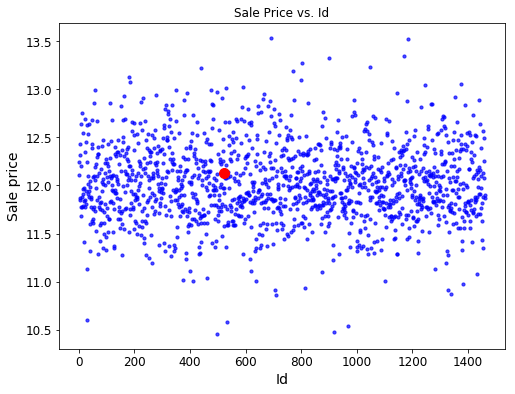

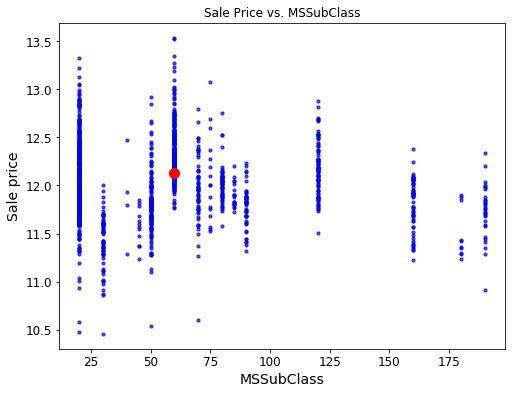

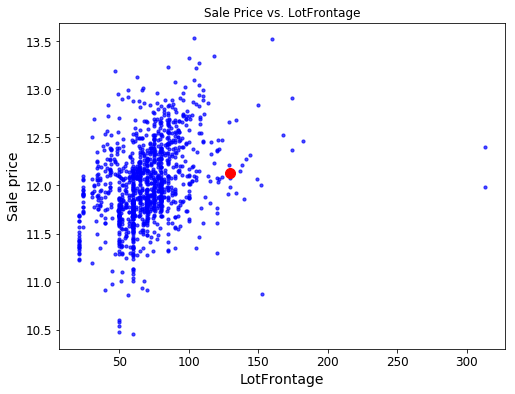

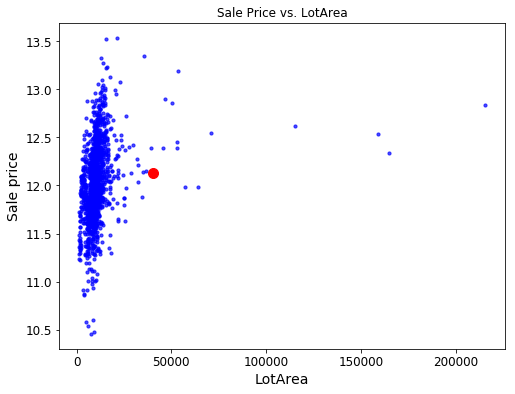

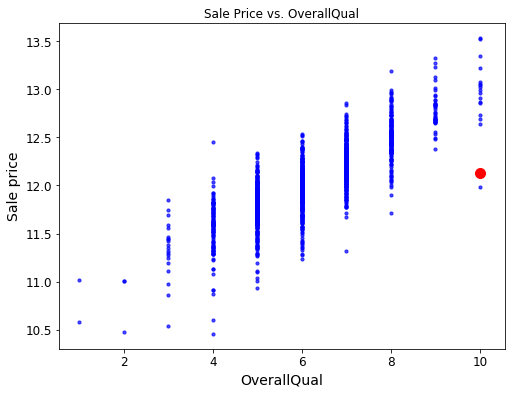

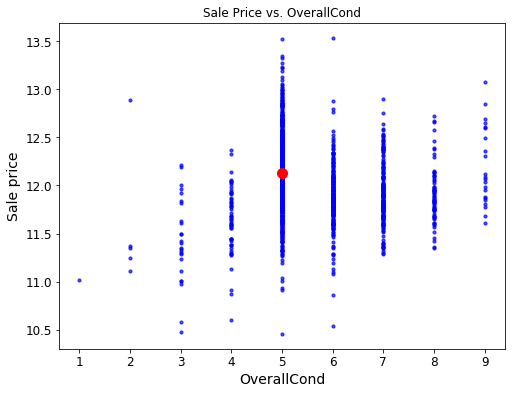

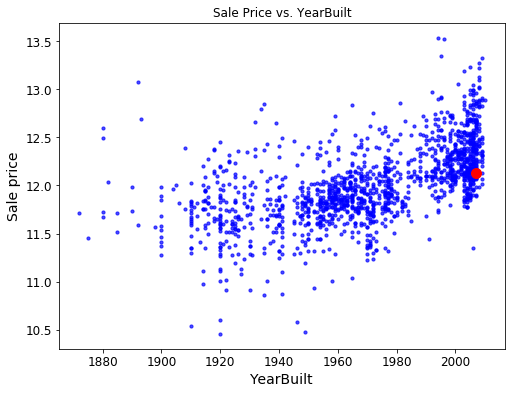

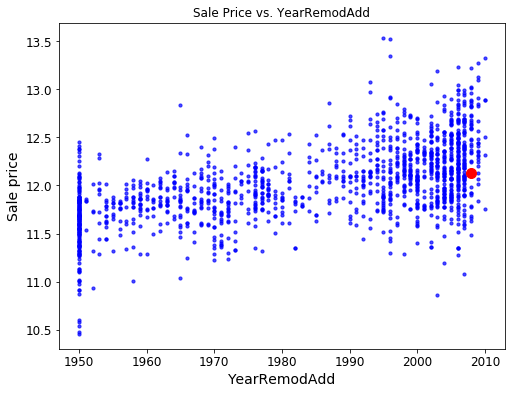

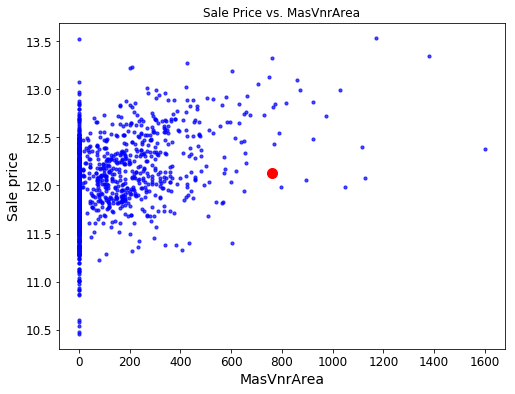

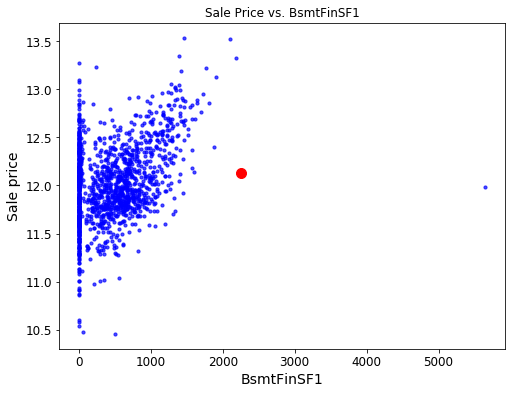

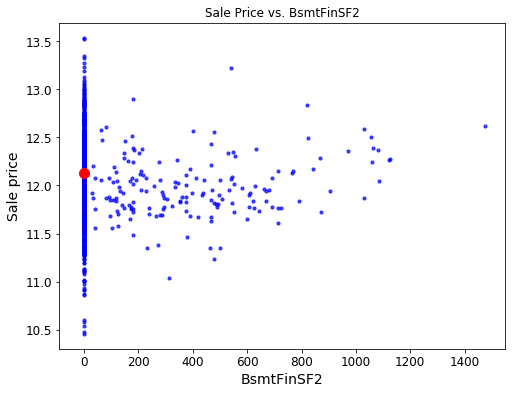

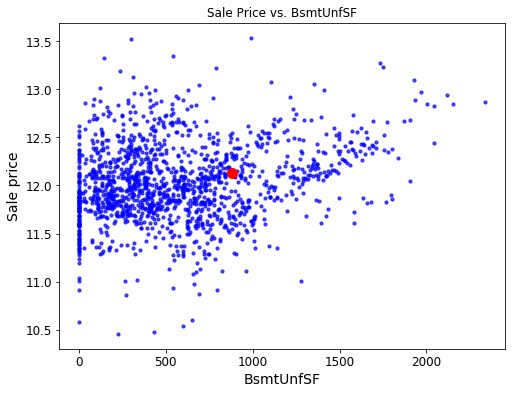

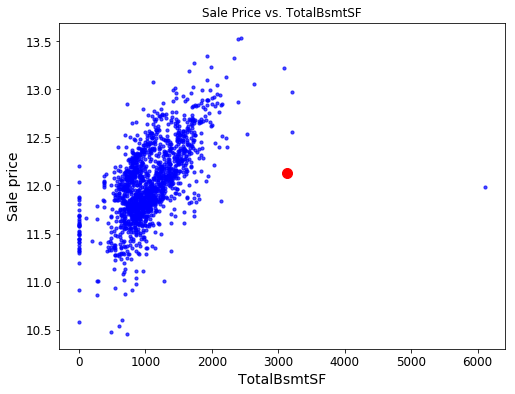

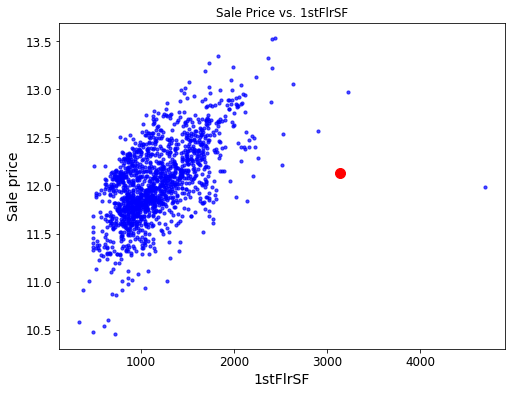

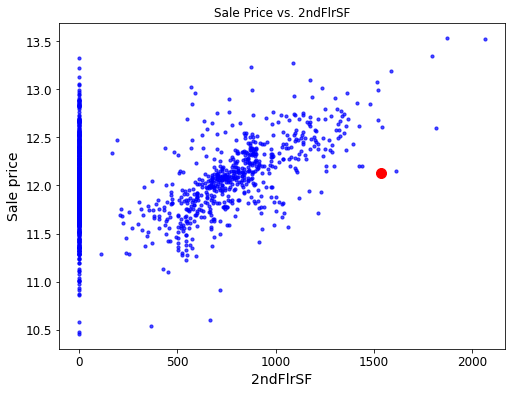

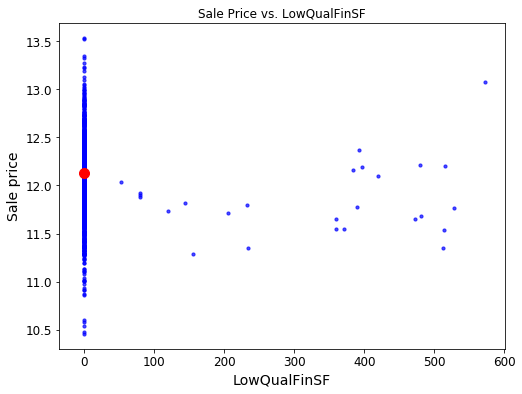

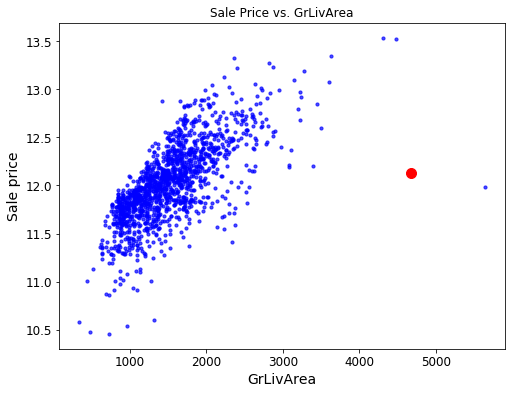

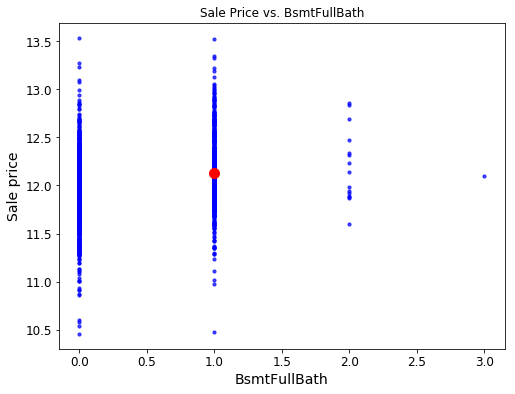

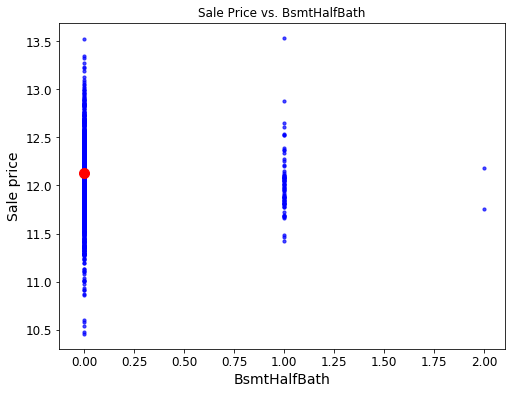

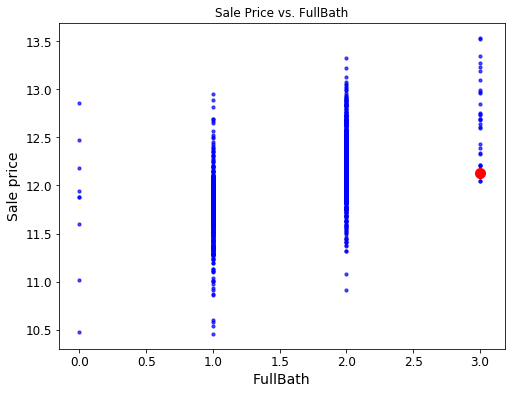

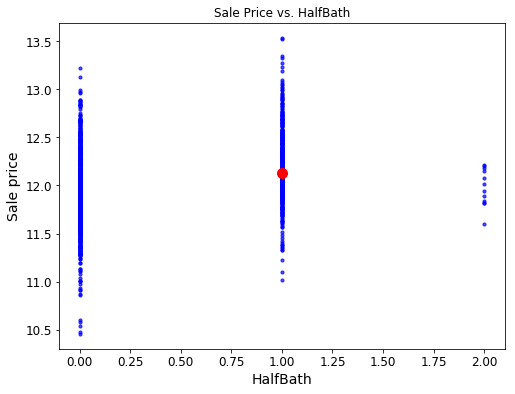

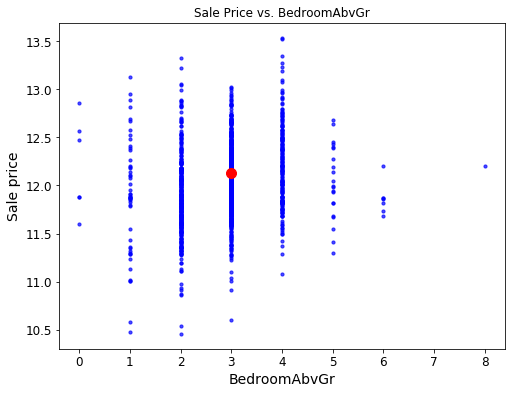

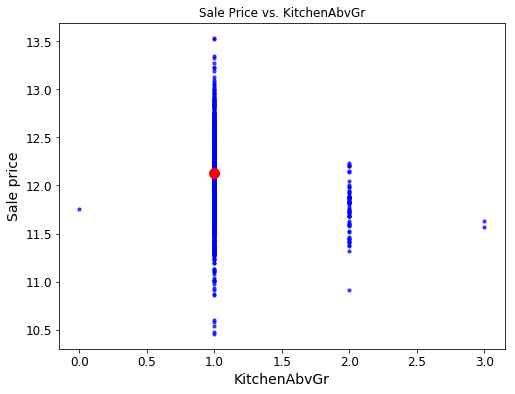

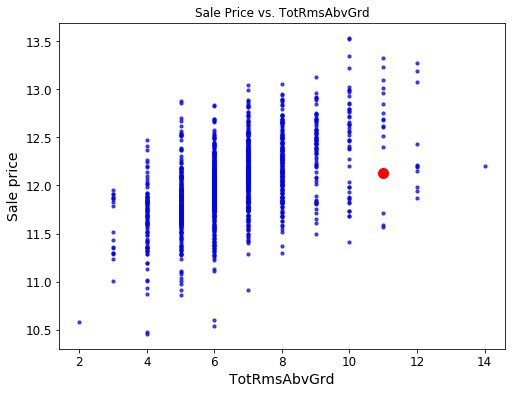

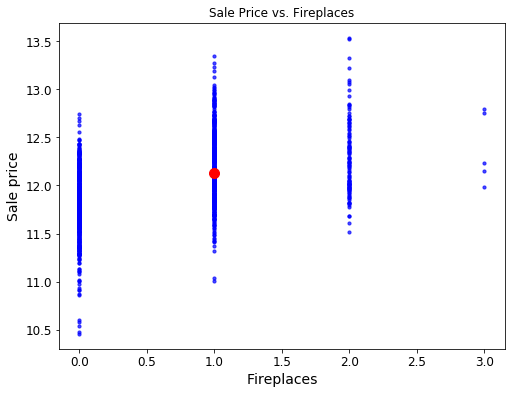

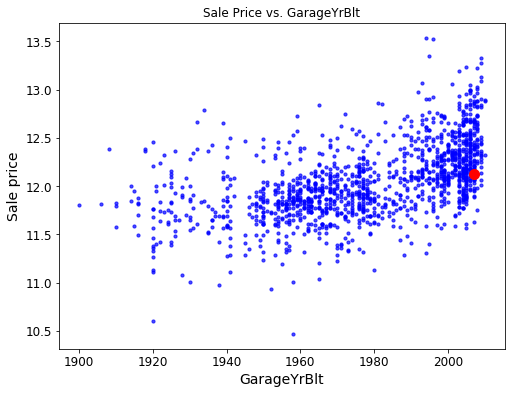

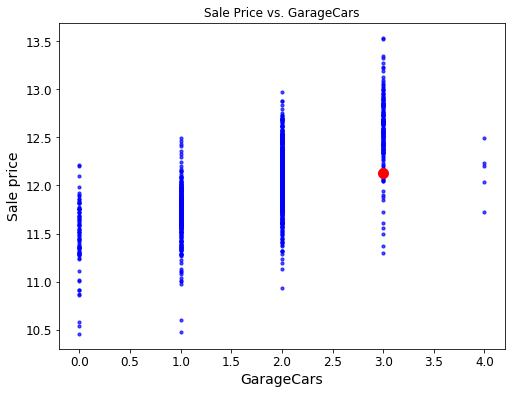

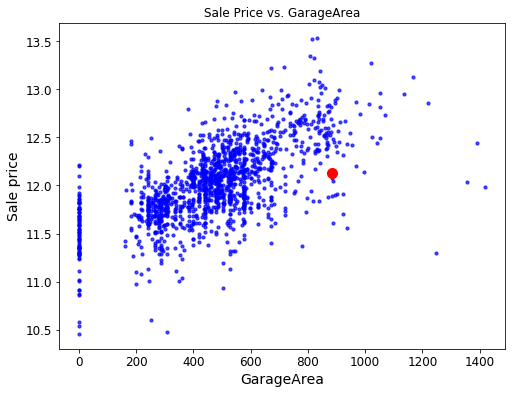

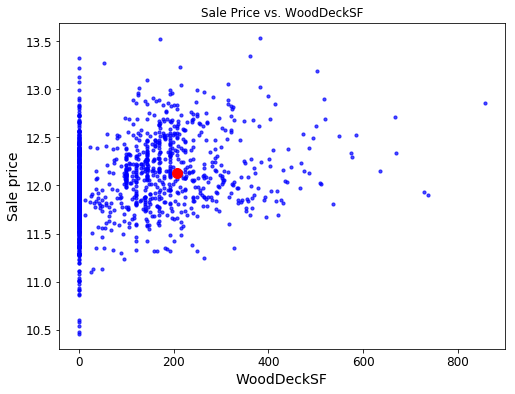

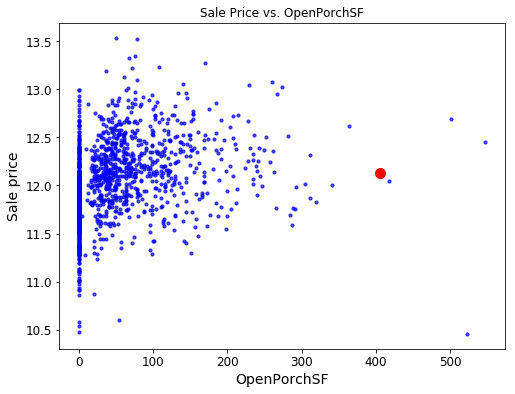

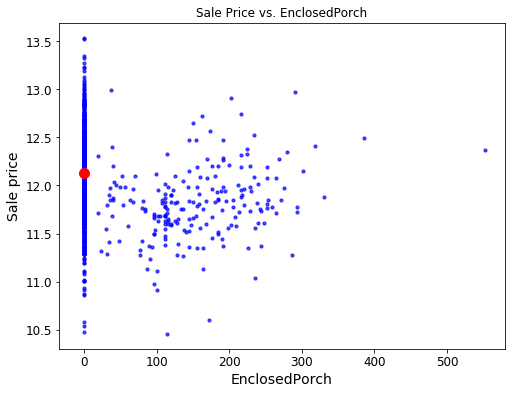

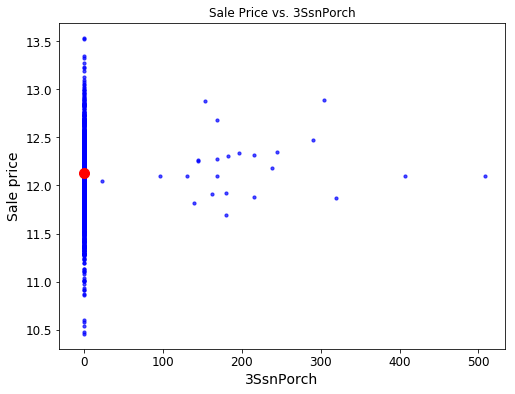

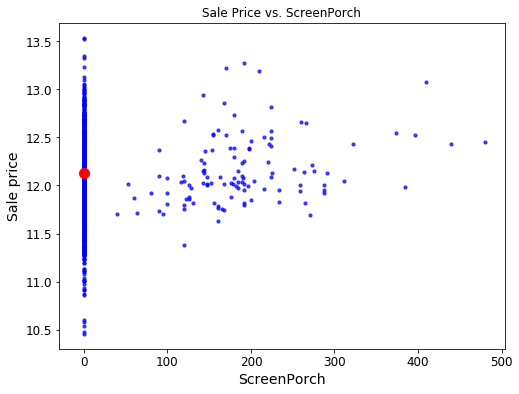

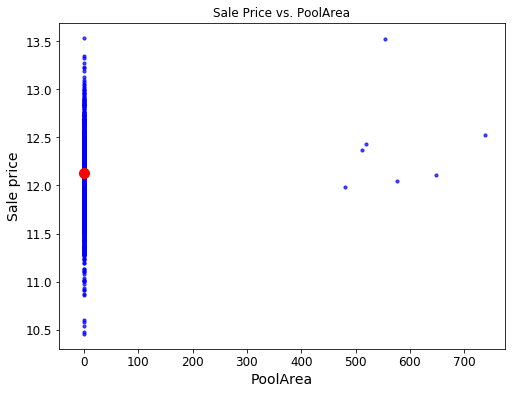

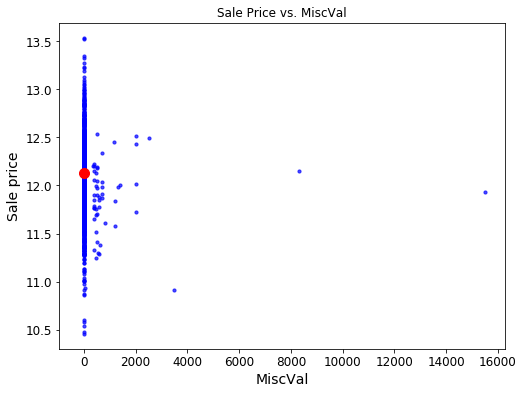

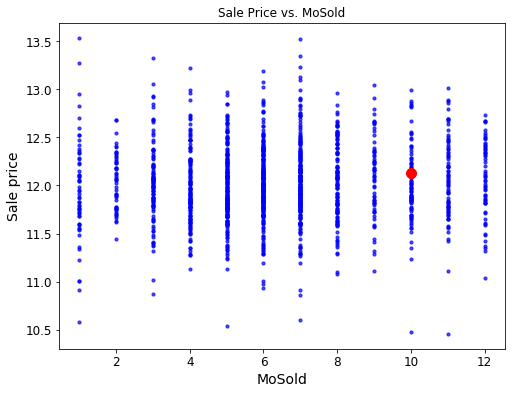

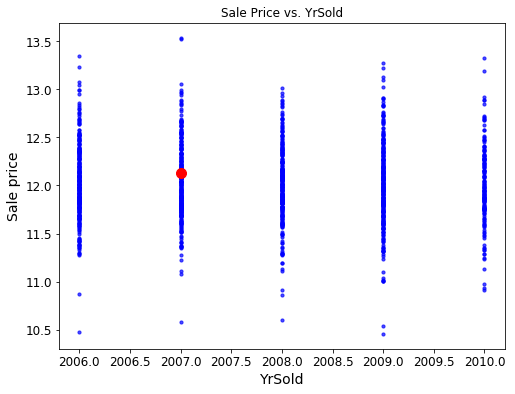

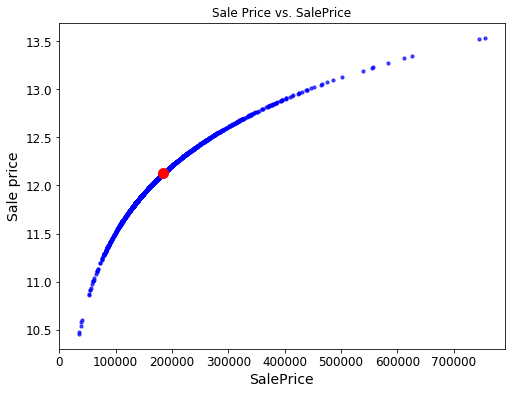

In [19]:
# Let's plot the max 

def scatter_outliers(df):
    import matplotlib.pyplot as plt
    
    outliers = np.abs(pred['resid_log'])>= pred['resid_log'].max()
    
    cols = df.columns.tolist()
    ## Loop over the columns and create the scatter plots
    for col in cols:
        
        if(df[col].dtype in [np.int64, np.int32, np.float64]):

            ## Now make the plots
            fig = plt.figure(figsize=(8, 6))
            fig.clf()
            ax = fig.gca()
            plt.scatter(df[col][outliers == 0], y[outliers == 0], marker='o', color='blue',alpha=0.7,s = 10,label='normal')
            plt.scatter(df[col][outliers == 1], y[outliers == 1], marker='o', color='red',alpha=1,s = 100,label='Outliers')

            ax.set_xlabel(col)
            ax.set_ylabel('Sale price')
            ax.set_title('Sale Price vs. ' + col)
            
    return 'Done'

%matplotlib inline
#scatter(train, num_cols)

outliers = np.abs(pred['resid_log'])>= pred['resid_log'].max()
print(DataFrame(train)[outliers==1])
scatter_outliers(DataFrame(train))

### Conclusion:
 
 => We will delete the points which shows GrLivArea below 4000 feet because there are partial sales and doesn't reflect the real price of the house. We showed that those points were in the 1% points with the biggest error, so it's a good catch to improve our model
 
Hope this notebook can be re-taken by other machine learners who want to illustrate the outliers in chart for all features.

Please contact me if you have any suggestions.

baptistequidet@gmail.com
